# Загрузка и подготовка датасета

In [38]:
!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
!unzip DIV2K_train_HR.zip #  Датасет

--2024-09-19 15:34:17--  http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip [following]
--2024-09-19 15:34:18--  https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3530603713 (3.3G) [application/zip]
Saving to: ‘DIV2K_train_HR.zip.1’

DIV2K_train_HR.zip.  90%[=================>  ]   2.97G  33.8MB/s    eta 11s    ^C
Archive:  DIV2K_train_HR.zip
replace DIV2K_train_HR/0103.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

Также вручную необходимо загрузить SET5 и SET14, создать папки new_img и new_img_14

## Импорт библиотек

In [66]:
import torch
import math
from os import listdir
import numpy as np
from torch.autograd import Variable

from PIL import Image
from os.path import join
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, RandomCrop, ToTensor, ToPILImage, CenterCrop, Resize

In [67]:
torch.autograd.set_detect_anomaly(True)

In [68]:
UPSCALE_FACTOR = 4
CROP_SIZE = 88

Задаем коэффициент увеличения (UPSCALING_FACTOR), который определяет, насколько нужно увеличить разрешение изображения, и размер обрезки (CROP_SIZE), который задаёт размеры изображений для обучения

In [69]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

## Функции для подготовки данных

In [70]:
def is_image_file(filename):
    return any(filename.endswith(extension) for extension in ['.png', '.jpg', '.jpeg', '.PNG', '.JPG', '.JPEG'])


def calculate_valid_crop_size(crop_size, upscale_factor):
    return crop_size - (crop_size % upscale_factor)


def train_hr_transform(crop_size):
    return Compose([
        RandomCrop(crop_size),
        ToTensor(),
    ])


def train_lr_transform(crop_size, upscale_factor):
    return Compose([
        ToPILImage(),
        Resize(crop_size // upscale_factor, interpolation=Image.BICUBIC),
        ToTensor()
    ])


def display_transform():
    return Compose([
        ToPILImage(),
        Resize(400),
        CenterCrop(400),
        ToTensor()
    ])

**train_hr_transform** выполняет обрезку изображения до заданного размера и преобразует его в тензор для использования в модели.

**train_lr_transform** использует изображение высокого разрешения, уменьшает его до низкого разрешения с помощью метода бикубической интерполяции, что нужно для создания обучающего примера с уменьшенным изображением.

**calculate_valid_crop_size** корректирует размер обрезки изображения так, чтобы его можно было масштабировать на целое число без остатка.


## Создание обучающего датасета

In [108]:
class TrainDatasetFromFolder(Dataset):
    def __init__(self, dataset_dir, crop_size, upscale_factor):
        super(TrainDatasetFromFolder, self).__init__()
        self.image_filenames = [join(dataset_dir, x) for x in listdir(dataset_dir) if is_image_file(x)]
        crop_size = calculate_valid_crop_size(crop_size, upscale_factor)
        self.hr_transform = train_hr_transform(crop_size)
        self.lr_transform = train_lr_transform(crop_size, upscale_factor)

    def __getitem__(self, index):
        hr_image = self.hr_transform(Image.open(self.image_filenames[index]))
        lr_image = self.lr_transform(hr_image)
        return lr_image, hr_image

    def __len__(self):
        return len(self.image_filenames)

In [109]:
train_set = TrainDatasetFromFolder("DIV2K_train_HR", crop_size=CROP_SIZE,
                                   upscale_factor=UPSCALE_FACTOR)
trainloader = DataLoader(train_set, batch_size=64, num_workers=4, shuffle=True)

In [73]:
train_set.__getitem__(1)[0][0].size()

torch.Size([22, 22])

## ВЫВОД ИЗОБРАЖЕНИЙ

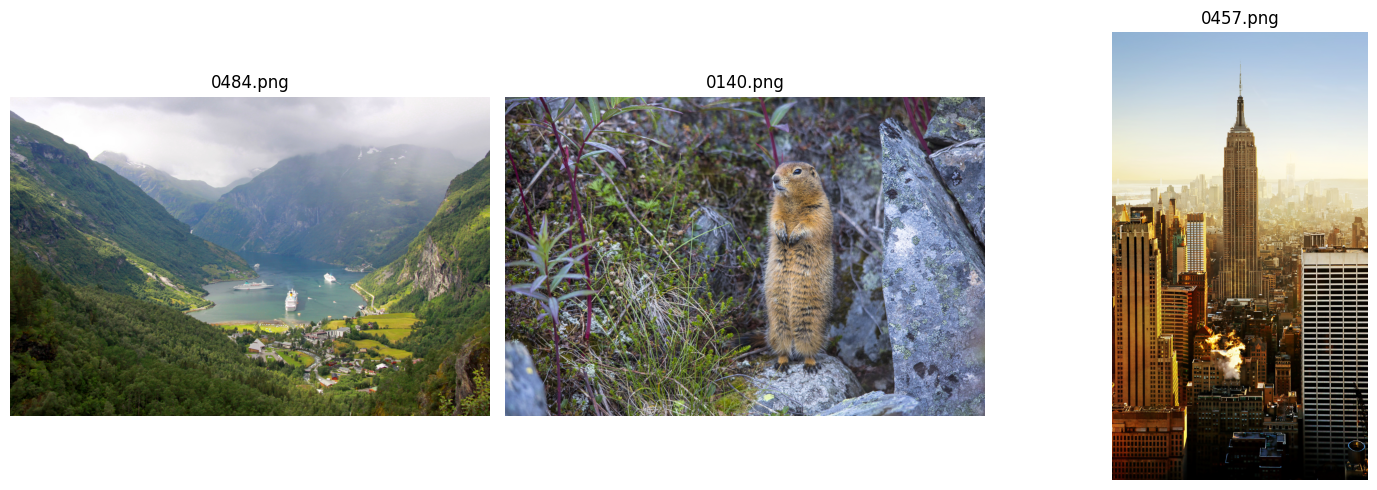

In [74]:
import matplotlib.pyplot as plt
import cv2
import os

def display_dataset_images(image_dir, num_images=5, cols=2, cmap=None):
    image_file_names = os.listdir(image_dir)[:num_images]
    rows = (len(image_file_names) + cols - 1) // cols
    plt.figure(figsize=(15, 5 * rows))

    for i, image_file_name in enumerate(image_file_names):
        image_path = os.path.join(image_dir, image_file_name)
        img = cv2.imread(image_path, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(rows, cols, i + 1)
        plt.imshow(img, cmap=cmap)
        plt.title(image_file_name)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


image_dir = '/content/DIV2K_train_HR'
display_dataset_images(image_dir, num_images=3, cols=3)

# МОДЕЛЬ

In [75]:
from torch import nn, optim

### Residual Block

In [76]:
class ResidualBlock(nn.Module):
  def __init__(self, channels):
    super(ResidualBlock, self).__init__()
    self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
    self.bn1 = nn.BatchNorm2d(channels)
    self.prelu = nn.PReLU()
    self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
    self.bn2 = nn.BatchNorm2d(channels)
  def forward(self, x):
    residual = self.conv1(x)
    residual = self.bn1(residual)
    residual = self.prelu(residual)
    residual = self.conv2(residual)
    residual = self.bn2(residual)
    return x + residual


### UpsampleBlock
Этот блок отвечает за увеличение разрешения изображения

In [77]:
class UpsampleBlock(nn.Module):
  def __init__(self, in_channels, up_scale):
    super(UpsampleBlock, self).__init__()
    self.conv = nn.Conv2d(in_channels, in_channels * up_scale ** 2,
                          kernel_size=3, padding=1)
    self.pixel_shuffle = nn.PixelShuffle(up_scale)
    self.prelu = nn.PReLU()
  def forward(self, x):
    x = self.conv(x)
    x = self.pixel_shuffle(x)
    x = self.prelu(x)
    return x

## Генератор (Generator)
Генератор — это основная сеть, которая повышает разрешение изображения. Он использует сверточные слои, остаточные блоки и блоки увеличения разрешения, чтобы на выходе получить изображение с высоким разрешением.

In [78]:
class Generator(nn.Module):
  def __init__(self, scale_factor):
    super(Generator, self).__init__()
    upsample_block_num = int(math.log(scale_factor, 2))

    self.block1 = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=9, padding=4),
        nn.PReLU()
    )

    self.block2 = ResidualBlock(64)
    self.block3 = ResidualBlock(64)
    self.block4 = ResidualBlock(64)
    self.block5 = ResidualBlock(64)
    self.block6 = ResidualBlock(64)
    self.block7 = nn.Sequential(
        nn.Conv2d(64, 64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64)
    )
    block8 = [UpsampleBlock(64, 2) for _ in range(upsample_block_num)]
    block8.append(nn.Conv2d(64, 3, kernel_size=9, padding=4))
    self.block8 = nn.Sequential(*block8)
  def forward(self, x):
    block1 = self.block1(x)
    block2 = self.block2(block1)
    block3 = self.block3(block2)
    block4 = self.block4(block3)
    block5 = self.block5(block4)
    block6 = self.block6(block5)
    block7 = self.block7(block6)
    block8 = self.block8(block1 + block7)
    return (torch.tanh(block8) + 1) / 2

## Дискриминатор (Discriminator)
Дискриминатор — это сеть, которая отличает сгенерированные изображения от реальных. Она обучается на задаче бинарной классификации: является ли изображение "реальным" (настоящим) или "поддельным" (сгенерированным).

In [79]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.net = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=3, padding=1),
        nn.LeakyReLU(0.2),

        nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2),

        nn.Conv2d(64, 128, kernel_size=3, padding=1),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2),

        nn.Conv2d(128, 256, kernel_size=3, padding=1),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2),

        nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2),

        nn.Conv2d(256, 512, kernel_size=3, padding=1),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2),

        nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2),

        nn.AdaptiveAvgPool2d(1),
        nn.Conv2d(512, 1024, kernel_size=1),
        nn.LeakyReLU(0.2),
        nn.Conv2d(1024, 1, kernel_size=1)
    )
  def forward(self, x):
    batch_size=x.size()[0]
    return torch.sigmoid(self.net(x).view(batch_size))

Таким образом это работает так, генератор создает высокоразрешенные изображения, используя остаточные блоки и блоки увеличения разрешения.
Дискриминатор пытается отличить реальные изображения от сгенерированных.

## функция потерь генератора


Функция потерь генератора включает несколько компонентов:

Adversarial Loss — помогает генератору создавать изображения, которые могут обмануть дискриминатор.

Perceptual Loss — оценивает качество изображения через разницу в признаках, извлекаемых из предобученной сети VGG16, чтобы улучшить детали изображения.

Image Loss (MSE) — минимизирует разницу на уровне пикселей между сгенерированными изображениями и реальными.

TV Loss — делает изображение более гладким.

In [80]:
from torchvision.models.vgg import vgg16

In [81]:
# Generator Loss
class TVLoss(nn.Module):
  def __init__(self, tv_loss_weight=1):
    super(TVLoss, self).__init__()
    self.tv_loss_weight=tv_loss_weight
  def forward(self, x):
    batch_size=x.size()[0]
    h_x = x.size()[2]
    w_x = x.size()[3]

    count_h = self.tensor_size(x[:, :, 1:, :])
    count_w = self.tensor_size(x[:, :, :, 1:])

    h_tv = torch.pow(x[:, :, 1:, :] - x[:, :, :h_x - 1, :], 2).sum()
    w_tv = torch.pow(x[:, :, :, 1:] - x[:, :, :, :w_x - 1], 2).sum()
    return self.tv_loss_weight * 2 * (h_tv / count_h + w_tv / count_w) / batch_size

  @staticmethod
  def tensor_size(t):
    return t.size()[1] * t.size()[2] * t.size()[3]

In [82]:
class GeneratorLoss(nn.Module):
  def __init__(self):
    super(GeneratorLoss, self).__init__()
    vgg = vgg16(pretrained=True)
    loss_network = nn.Sequential(*list(vgg.features)[:31]).eval()
    for param in loss_network.parameters():
      param.requires_grad = False
    self.loss_network = loss_network
    self.mse_loss = nn.MSELoss()
    self.tv_loss = TVLoss()
  def forward(self, out_labels, out_images, target_images):
    adversial_loss = torch.mean(1 - out_labels)
    perception_loss = self.mse_loss(out_images, target_images)
    image_loss = self.mse_loss(out_images, target_images)
    tv_loss = self.tv_loss(out_images)
    return image_loss + 0.001 * adversial_loss + 0.006 * perception_loss + 2e-8 * tv_loss


### Инициализация моделей и оптимизаторов

In [83]:
device  = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [84]:
netG = Generator(UPSCALE_FACTOR)
netD = Discriminator()

In [85]:
generator_criterion = GeneratorLoss()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [86]:
generator_criterion = generator_criterion.to(device)
netG = netG.to(device)
netD = netD.to(device)

In [87]:
optimizerG = optim.Adam(netG.parameters(), lr=0.0002)
optimizerD = optim.Adam(netD.parameters(), lr=0.0002)

In [88]:
results = {
    "d_loss":[],
    "g_loss":[],
    "d_score": [],
    "g_score": []
}

# ОБУЧЕНИЕ

In [89]:
## Тут код обучения
from tqdm import tqdm
import os

In [25]:
N_EPOCHS = 5 # 50 эпох было

In [26]:
for epoch in range(1, N_EPOCHS + 1):
  train_bar = tqdm(trainloader)
  running_results = {'batch_sizes':0, 'd_loss':0,
                     "g_loss":0, "d_score":0, "g_score":0}

  netG.train()
  netD.train()
  for data, target in train_bar:
    g_update_first = True
    batch_size = data.size(0)
    running_results['batch_sizes'] += batch_size

    real_img = Variable(target)
    real_img = real_img.to(device)
    z = Variable(data)
    z = z.to(device)

    ## обновляем Дискриминатор
    fake_img = netG(z)
    netD.zero_grad()
    real_out = netD(real_img).mean()
    fake_out = netD(fake_img).mean()
    d_loss = 1 - real_out + fake_out
    d_loss.backward(retain_graph = True)
    optimizerD.step()

    ## обновляем Генератор
    fake_img = netG(z)
    fake_out = netD(fake_img).mean()
    netG.zero_grad()
    g_loss = generator_criterion(fake_out, fake_img, real_img)
    g_loss.backward()

    fake_img = netG(z)
    fake_out = netD(fake_img).mean()

    optimizerG.step()

    running_results['g_loss'] += g_loss.item() * batch_size
    running_results['d_loss'] += d_loss.item() * batch_size
    running_results['d_score'] += real_out.item() * batch_size
    running_results['g_score'] += real_out.item() * batch_size

    ## progress bar
    train_bar.set_description(desc="[%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f" % (
        epoch, N_EPOCHS, running_results['d_loss'] / running_results['batch_sizes'],
        running_results['g_loss'] / running_results['batch_sizes'],
        running_results['d_score'] / running_results['batch_sizes'],
        running_results['g_score'] / running_results['batch_sizes']
    ))
  netG.eval()

[1/5] Loss_D: 0.8065 Loss_G: 0.0402 D(x): 0.5672 D(G(z)): 0.5672: 100%|██████████| 13/13 [01:07<00:00,  5.22s/it]
[2/5] Loss_D: 0.5895 Loss_G: 0.0169 D(x): 0.6718 D(G(z)): 0.6718: 100%|██████████| 13/13 [01:04<00:00,  5.00s/it]
[3/5] Loss_D: 0.3786 Loss_G: 0.0133 D(x): 0.8196 D(G(z)): 0.8196: 100%|██████████| 13/13 [01:05<00:00,  5.02s/it]
[4/5] Loss_D: 0.4062 Loss_G: 0.0122 D(x): 0.7490 D(G(z)): 0.7490: 100%|██████████| 13/13 [01:05<00:00,  5.01s/it]
[5/5] Loss_D: 0.5628 Loss_G: 0.0108 D(x): 0.7719 D(G(z)): 0.7719: 100%|██████████| 13/13 [01:05<00:00,  5.05s/it]


In [27]:
# просто посмотрим чтобы успешно обучала 5 эпох

# SET5


Здесь сначала запустим с моделью обученной на 5 эпохах, а затем на 50 эпохах

In [118]:
# !pip install datasets super-image

In [119]:
import os
# from datasets import load_dataset
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

In [120]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

class Set5Dataset(Dataset):
    def __init__(self, dataset_dir):
        super(Set5Dataset, self).__init__()
        # список файлов изображений
        self.image_filenames = [os.path.join(dataset_dir, x) for x in os.listdir(dataset_dir) if self.is_image_file(x)]
        self.transform = transforms.Compose([
            transforms.Resize((100,100)),  # Изменяем размер изображения
            transforms.ToTensor()  # Преобразуем в тензор
        ])

    def __getitem__(self, index):
        image = Image.open(self.image_filenames[index]).convert('RGB')
        return self.transform(image)

    def __len__(self):
        return len(self.image_filenames)

    def is_image_file(self, filename):
        return any(filename.endswith(extension) for extension in [".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff"])


dataset_dir = "/content/SET5/LR"  # Путь
dataset = Set5Dataset(dataset_dir)


dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [121]:
# from datasets import load_dataset

# # Загрузка набора данных Set5
# # dataset = load_dataset('/content/SET5/HR', split='all')
# # dataset = TrainDatasetFromFolder('/content/SET5/HR')

# testloader = DataLoader(set5_dataset, batch_size=1, num_workers=4, shuffle=True)

In [122]:
dataset.__len__()

5

In [123]:
dataset.__getitem__(1)

tensor([[[0.1294, 0.1294, 0.1294,  ..., 0.0314, 0.0314, 0.0314],
         [0.1059, 0.1059, 0.1059,  ..., 0.0314, 0.0314, 0.0314],
         [0.0863, 0.0824, 0.0824,  ..., 0.0314, 0.0314, 0.0314],
         ...,
         [0.5725, 0.5765, 0.5843,  ..., 0.5725, 0.5373, 0.5176],
         [0.5608, 0.5451, 0.5176,  ..., 0.5922, 0.5686, 0.5529],
         [0.6078, 0.5882, 0.5529,  ..., 0.6000, 0.5647, 0.5451]],

        [[0.0784, 0.0784, 0.0784,  ..., 0.0314, 0.0314, 0.0314],
         [0.0627, 0.0627, 0.0627,  ..., 0.0314, 0.0314, 0.0314],
         [0.0471, 0.0471, 0.0471,  ..., 0.0314, 0.0314, 0.0314],
         ...,
         [0.3882, 0.3922, 0.3961,  ..., 0.3961, 0.3725, 0.3529],
         [0.3922, 0.3647, 0.3255,  ..., 0.4275, 0.4039, 0.3882],
         [0.4431, 0.4118, 0.3647,  ..., 0.4353, 0.4039, 0.3843]],

        [[0.1137, 0.1098, 0.1059,  ..., 0.0235, 0.0235, 0.0235],
         [0.0902, 0.0863, 0.0824,  ..., 0.0235, 0.0235, 0.0235],
         [0.0627, 0.0588, 0.0510,  ..., 0.0235, 0.0235, 0.

Тут посмотрим корректно ли работает модель

In [126]:
import os
from torchvision.utils import save_image

#папка для сохранения сгенерированных изображений (НАДО СОЗДАТЬ)
output_dir = "new_img"
os.makedirs(output_dir, exist_ok=True)

netG.eval()

# Применяем модель к тестовому набору
with torch.no_grad():
    for i, images in enumerate(dataloader):
        z = Variable(images).to(device)
        fake_img = netG(z)  # Генерируем изображение
        save_image(fake_img, os.path.join(output_dir, f"generated_{i}.png"))  # Сохраняем

# МЕТРИКИ

In [127]:
# input_img — это изображение, которое подается на вход генератору
# real_img — это эталонное изображение высокого разрешения
# Используем input_img для генерации выходного изображения fake_img, а затем вычисляем метрики, сравнивая fake_img с real_img

## psnr

In [128]:
import math
import numpy as np

def calculate_psnr(img1, img2):

    img1 = img1.squeeze(0).cpu().numpy().transpose(1, 2, 0) * 255.0
    img2 = img2.squeeze(0).cpu().numpy().transpose(1, 2, 0) * 255.0


    img1 = np.clip(img1, 0, 255)
    img2 = np.clip(img2, 0, 255)

    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)

    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    mse = np.mean((img1 - img2)**2)
    if mse == 0:
        return float('inf')
    return 20 * math.log10(255.0 / math.sqrt(mse))


## SSIM

In [129]:
from skimage.metrics import structural_similarity as ssim
import numpy as np

def calculate_ssim(img1, img2):

    img1 = img1.squeeze(0).cpu().numpy().transpose(1, 2, 0) * 255.0
    img2 = img2.squeeze(0).cpu().numpy().transpose(1, 2, 0) * 255.0

    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)

    if img1.shape != img2.shape:
        raise ValueError('Input images must have the same dimensions.')

    if img1.ndim == 2:
        return ssim(img1, img2, data_range=255)
    elif img1.ndim == 3 and img1.shape[2] == 3:  # Цветное изображение
        ssim_values = []
        for i in range(3):
            ssim_values.append(ssim(img1[:, :, i], img2[:, :, i], data_range=255))
        return np.mean(ssim_values)
    else:
        raise ValueError('Unsupported image dimensions.')


# LPIPS

In [130]:
 !pip install lpips

In [131]:
import torch
import lpips

# Инициализация LPIPS модели
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loss_fn = lpips.LPIPS(net='vgg').to(device)

def calculate_lpips(img1, img2):
    img1 = img1.to(device)
    img2 = img2.to(device)


    # img1 = lpips.im2tensor(img1)
    # img2 = lpips.im2tensor(img2)

    # Вычисление LPIPS
    with torch.no_grad():
        lpips_value = loss_fn(img1, img2).item()

    return lpips_value

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/vgg.pth


# Считаем метрики для SET5


Здесь загружает эталонные изображения высокого разрешения (HR) и изображения с низким разрешением (LR) из набора Set5. После этого модель генератора (netG) используется для создания изображений с высоким разрешением (SR) на основе LR. Сгенерированные изображения сохраняются, а для каждого изображения рассчитываются и выводятся метрики PSNR, SSIM и LPIPS для сравнения качества с эталонными изображениями

In [132]:
import os
from torchvision import transforms
from PIL import Image
import torch
import numpy as np
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import lpips
import re



transform = transforms.Compose([
    transforms.Resize((400, 400)),
    transforms.ToTensor()
])

transform2 = transforms.Compose([
    transforms.ToTensor()
])

transform3 = transforms.Compose([
    transforms.Resize((400, 400))
])

# Переключаем модель в режим оценки
netG.eval()

# Путь к директории с эталонными изображениями
hr_dir = "/content/SET5/HR"
# Путь к директории для сохранения сгенерированных изображений
sr_dir = "/content/new_img"

lr_dir = "/content/SET5/LR"  # Путь к низким

os.makedirs(sr_dir, exist_ok=True)


results = []

# Применяем модель к тестовому набору
with torch.no_grad():
    hr_filenames = sorted(os.listdir(hr_dir))
    for i, hr_filename in enumerate(hr_filenames):
        hr_path = os.path.join(hr_dir, hr_filename)

        #  реальное изображение (HR)
        real_img = Image.open(hr_path).convert("RGB")
        real_img = transform(real_img).unsqueeze(0).to(device)

        # входное изображение
        lr_filename = re.sub(r'(.png)', r'x4\1', hr_filename)
        input_img_path = os.path.join(lr_dir, lr_filename)
        input_img = Image.open(input_img_path).convert("RGB")
        input_img = transform2(input_img).unsqueeze(0).to(device)


        fake_img = netG(input_img)  # Сгенерированное изображение (SR)
        fake_img = transform3(fake_img)


        # Сохраняем сгенерированное изображение
        save_path = os.path.join(sr_dir, f"generated_{i}.png")
        fake_img_pil = transforms.ToPILImage()(fake_img.squeeze(0).cpu())
        fake_img_pil.save(save_path)

        # Вывод размеров изображений
        real_img_size = real_img.squeeze(0).cpu().numpy().shape
        fake_img_size = fake_img.squeeze(0).cpu().numpy().shape
        print(f"Размеры изображений - Real: {real_img_size}, Fake: {fake_img_size}")

        # Вычисляем метрики для изображения

        psnr_value = calculate_psnr(fake_img, real_img)

        SSIM = calculate_ssim(fake_img, real_img)

        lpips = calculate_lpips(fake_img, real_img)

        # Сохраняем результаты
        results.append({
            'Изображение': i,
            "PSNR": psnr_value,
            "SSIM": SSIM,
            'lpips': lpips,

        })


Размеры изображений - Real: (3, 400, 400), Fake: (3, 400, 400)
Размеры изображений - Real: (3, 400, 400), Fake: (3, 400, 400)
Размеры изображений - Real: (3, 400, 400), Fake: (3, 400, 400)
Размеры изображений - Real: (3, 400, 400), Fake: (3, 400, 400)
Размеры изображений - Real: (3, 400, 400), Fake: (3, 400, 400)


In [133]:
results #vivodim metriki

[{'Изображение': 0,
  'PSNR': 26.518605795092093,
  'SSIM': 0.86413002890882,
  'lpips': 0.23067264258861542},
 {'Изображение': 1,
  'PSNR': 25.152802748785422,
  'SSIM': 0.7126024310846075,
  'lpips': 0.31228479743003845},
 {'Изображение': 2,
  'PSNR': 22.084605355862976,
  'SSIM': 0.6731574014072343,
  'lpips': 0.3696613907814026},
 {'Изображение': 3,
  'PSNR': 26.60950433055287,
  'SSIM': 0.6559954644842722,
  'lpips': 0.3679974377155304},
 {'Изображение': 4,
  'PSNR': 24.515614118454955,
  'SSIM': 0.7737028459102516,
  'lpips': 0.3113851845264435}]

# При 50 эпохах

[{'Изображение': 0,
  'PSNR': 26.518605795092093,
  'SSIM': 0.86413002890882,
  'lpips': 0.23067264258861542},

 {'Изображение': 1,
  'PSNR': 25.152802748785422,
  'SSIM': 0.7126024310846075,
  'lpips': 0.31228479743003845},

 {'Изображение': 2,
  'PSNR': 22.084605355862976,
  'SSIM': 0.6731574014072343,
  'lpips': 0.3696613907814026},

 {'Изображение': 3,
  'PSNR': 26.60950433055287,
  'SSIM': 0.6559954644842722,
  'lpips': 0.3679974377155304},
  
 {'Изображение': 4,
  'PSNR': 24.515614118454955,
  'SSIM': 0.7737028459102516,
  'lpips': 0.3113851845264435}]

# ПРИ 5 эпохах
[{'Изображение': 0,
  'PSNR': 23.809964664080447,
  'SSIM': 0.7067333334331027,
  'lpips': 0.35889363288879395},

 {'Изображение': 1,
  'PSNR': 20.82486059983554,
  'SSIM': 0.5575793771921448,
  'lpips': 0.5438247323036194},


 {'Изображение': 2,
  'PSNR': 17.005372984720196,
  'SSIM': 0.46511677652251265,
  'lpips': 0.5764625668525696},


 {'Изображение': 3,
  'PSNR': 24.252608218946598,
  'SSIM': 0.6035800108313629,
  'lpips': 0.5383096933364868},

  
 {'Изображение': 4,
  'PSNR': 20.328709830280275,
  'SSIM': 0.6341640652754436,
  'lpips': 0.5038655400276184}]

# Заново обучим, и посмотрим метрики и лосы на 50 эпохах

Здесь метрики PSNR, SSIM и LPIPS были адаптированы для вычисления по батчам изображений

## psnr

In [113]:
import math
import numpy as np

def calculate_psnr(batch_fake, batch_real):
    """
    Вычисляет средний PSNR для батча изображений.
    """
    psnr_values = []

    for fake_img, real_img in zip(batch_fake, batch_real):
        fake_img = fake_img.detach().cpu().numpy().transpose(1, 2, 0) * 255.0
        real_img = real_img.detach().cpu().numpy().transpose(1, 2, 0) * 255.0

        fake_img = np.clip(fake_img, 0, 255)
        real_img = np.clip(real_img, 0, 255)

        fake_img = fake_img.astype(np.float64)
        real_img = real_img.astype(np.float64)

        mse = np.mean((fake_img - real_img)**2)
        if mse == 0:
            psnr_values.append(float('inf'))
        else:
            psnr_values.append(20 * math.log10(255.0 / math.sqrt(mse)))

    return np.mean(psnr_values)  # Возвращаем среднее значение PSNR

## SSIM

In [114]:
from skimage.metrics import structural_similarity as ssim
import numpy as np

def calculate_ssim(batch_fake, batch_real):
    """
    Вычисляет средний SSIM для батча изображений.
    """
    ssim_values = []

    for fake_img, real_img in zip(batch_fake, batch_real):
        fake_img = fake_img.detach().cpu().numpy().transpose(1, 2, 0) * 255.0
        real_img = real_img.detach().cpu().numpy().transpose(1, 2, 0) * 255.0

        fake_img = fake_img.astype(np.float64)
        real_img = real_img.astype(np.float64)

        if fake_img.shape != real_img.shape:
            raise ValueError('Input images must have the same dimensions.')

        if fake_img.ndim == 2:
            ssim_value = ssim(fake_img, real_img, data_range=255)
            ssim_values.append(ssim_value)
        elif fake_img.ndim == 3 and fake_img.shape[2] == 3:  # Цветные изображения
            channel_ssim_values = []
            for i in range(3):
                channel_ssim_values.append(ssim(fake_img[:, :, i], real_img[:, :, i], data_range=255))
            ssim_values.append(np.mean(channel_ssim_values))
        else:
            raise ValueError('Unsupported image dimensions.')

    return np.mean(ssim_values)  # Возвращаем среднее значение SSIM для батча

# LPIPS

In [115]:
import torch
import lpips

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loss_fn = lpips.LPIPS(net='vgg').to(device)

def calculate_lpips(batch_fake, batch_real):
    """
    Вычисляет средний LPIPS для батча изображений.

    """
    lpips_values = []

    for fake_img, real_img in zip(batch_fake, batch_real):
        fake_img = fake_img.to(device)
        real_img = real_img.to(device)

        # Вычисление LPIPS
        with torch.no_grad():
            lpips_value = loss_fn(fake_img.unsqueeze(0), real_img.unsqueeze(0)).item()

        lpips_values.append(lpips_value)

    return np.mean(lpips_values)  # Возвращаем среднее значение LPIPS

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/vgg.pth


/usr/local/lib/python3.10/dist-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_location='cpu'), st

In [64]:
!pip install wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 65.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.4/311.4 kB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.4 MB/s eta 0:00:00


In [101]:
import wandb

wandb.init(project="SRGAN_1", config={"learning_rate": 0.001, "epochs": N_EPOCHS})

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [116]:
N_EPOCHS = 50 # 5 эпох было

In [117]:
for epoch in range(1, N_EPOCHS + 1):
  train_bar = tqdm(trainloader)
  running_results = {'batch_sizes':0, 'd_loss':0,
                     "g_loss":0, "d_score":0, "g_score":0}

  netG.train()
  netD.train()
  for data, target in train_bar:
    g_update_first = True
    batch_size = data.size(0)
    running_results['batch_sizes'] += batch_size

    real_img = Variable(target)
    real_img = real_img.to(device)
    z = Variable(data)
    z = z.to(device)

    ## обновляем Дискриминатор
    fake_img = netG(z)
    netD.zero_grad()
    real_out = netD(real_img).mean()
    fake_out = netD(fake_img).mean()
    d_loss = 1 - real_out + fake_out
    d_loss.backward(retain_graph = True)
    optimizerD.step()

    ## обновляем Генератор
    fake_img = netG(z)
    fake_out = netD(fake_img).mean()
    netG.zero_grad()
    g_loss = generator_criterion(fake_out, fake_img, real_img)
    g_loss.backward()

    fake_img = netG(z)
    fake_out = netD(fake_img).mean()

    optimizerG.step()

    running_results['g_loss'] += g_loss.item() * batch_size
    running_results['d_loss'] += d_loss.item() * batch_size
    running_results['d_score'] += real_out.item() * batch_size
    running_results['g_score'] += real_out.item() * batch_size

    # Вывод размеров изображений
    real_img_size = real_img.squeeze(0).cpu().detach().numpy().shape
    fake_img_size = fake_img.squeeze(0).cpu().detach().numpy().shape
    print(f"Размеры изображений - Real: {real_img_size}, Fake: {fake_img_size}")

     # Логируем метрики (PSNR, SSIM и LPIPS) каждые несколько эпох или итераций
    if epoch % 1 == 0:  # Например, каждые 2 эпохи
        with torch.no_grad():
            # Вычисляем метрики с использованием ваших функций
            psnr_value = calculate_psnr(fake_img, real_img)
            ssim_value = calculate_ssim(fake_img, real_img)
            lpips_value = calculate_lpips(fake_img, real_img)

            # Логируем все метрики в W&B
            wandb.log({
                "epoch": epoch,
                "d_loss": running_results['d_loss'] / running_results['batch_sizes'],
                "g_loss": running_results['g_loss'] / running_results['batch_sizes'],
                "PSNR": psnr_value,
                "SSIM": ssim_value,
                "LPIPS": lpips_value,
                "D(x)": running_results['d_score'] / running_results['batch_sizes'],
                "D(G(z))": running_results['g_score'] / running_results['batch_sizes'],
            })

    # Обновление прогресс-бара
    train_bar.set_description(desc="[%d/%d] Loss_D: %.4f Loss_G: %.4f" % (
        epoch, N_EPOCHS,
        running_results['d_loss'] / running_results['batch_sizes'],
        running_results['g_loss'] / running_results['batch_sizes']
    ))

# Завершение работы W&B
wandb.finish()

  0%|          | 0/13 [00:00<?, ?it/s]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[1/50] Loss_D: 0.7963 Loss_G: 0.0343:   8%|▊         | 1/13 [00:27<05:25, 27.11s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[1/50] Loss_D: 0.7919 Loss_G: 0.0295:  15%|█▌        | 2/13 [00:29<02:21, 12.85s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[1/50] Loss_D: 0.8076 Loss_G: 0.0286:  23%|██▎       | 3/13 [00:32<01:23,  8.33s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[1/50] Loss_D: 0.7832 Loss_G: 0.0291:  31%|███       | 4/13 [00:35<00:55,  6.14s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[1/50] Loss_D: 0.7715 Loss_G: 0.0295:  38%|███▊      | 5/13 [00:49<01:09,  8.74s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[1/50] Loss_D: 0.7487 Loss_G: 0.0292:  46%|████▌     | 6/13 [00:52<00:47,  6.83s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[1/50] Loss_D: 0.7380 Loss_G: 0.0286:  54%|█████▍    | 7/13 [00:58<00:39,  6.65s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[1/50] Loss_D: 0.7289 Loss_G: 0.0279:  62%|██████▏   | 8/13 [01:01<00:27,  5.59s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[1/50] Loss_D: 0.7180 Loss_G: 0.0269:  69%|██████▉   | 9/13 [01:10<00:26,  6.66s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[1/50] Loss_D: 0.7113 Loss_G: 0.0260:  77%|███████▋  | 10/13 [01:13<00:15,  5.29s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[1/50] Loss_D: 0.6968 Loss_G: 0.0255:  85%|████████▍ | 11/13 [01:15<00:08,  4.40s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[1/50] Loss_D: 0.6847 Loss_G: 0.0247:  92%|█████████▏| 12/13 [01:16<00:03,  3.49s/it]

Размеры изображений - Real: (32, 3, 88, 88), Fake: (32, 3, 88, 88)


  0%|          | 0/13 [00:00<?, ?it/s]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[2/50] Loss_D: 0.5510 Loss_G: 0.0161:   8%|▊         | 1/13 [00:22<04:35, 22.96s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[2/50] Loss_D: 0.5362 Loss_G: 0.0157:  15%|█▌        | 2/13 [00:26<02:06, 11.48s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[2/50] Loss_D: 0.5419 Loss_G: 0.0163:  23%|██▎       | 3/13 [00:31<01:24,  8.43s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[2/50] Loss_D: 0.5376 Loss_G: 0.0162:  31%|███       | 4/13 [00:34<00:57,  6.39s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[2/50] Loss_D: 0.5112 Loss_G: 0.0169:  38%|███▊      | 5/13 [00:47<01:10,  8.78s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[2/50] Loss_D: 0.5221 Loss_G: 0.0166:  46%|████▌     | 6/13 [00:50<00:47,  6.79s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[2/50] Loss_D: 0.5281 Loss_G: 0.0173:  54%|█████▍    | 7/13 [00:53<00:32,  5.49s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[2/50] Loss_D: 0.5336 Loss_G: 0.0166:  62%|██████▏   | 8/13 [00:55<00:22,  4.56s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[2/50] Loss_D: 0.5502 Loss_G: 0.0161:  69%|██████▉   | 9/13 [01:08<00:28,  7.06s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[2/50] Loss_D: 0.5471 Loss_G: 0.0160:  77%|███████▋  | 10/13 [01:10<00:16,  5.40s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[2/50] Loss_D: 0.5456 Loss_G: 0.0162:  85%|████████▍ | 11/13 [01:11<00:08,  4.30s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[2/50] Loss_D: 0.5405 Loss_G: 0.0161:  92%|█████████▏| 12/13 [01:13<00:03,  3.41s/it]

Размеры изображений - Real: (32, 3, 88, 88), Fake: (32, 3, 88, 88)


  0%|          | 0/13 [00:00<?, ?it/s]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[3/50] Loss_D: 0.3925 Loss_G: 0.0121:   8%|▊         | 1/13 [00:25<05:03, 25.29s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[3/50] Loss_D: 0.3840 Loss_G: 0.0140:  15%|█▌        | 2/13 [00:28<02:14, 12.23s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[3/50] Loss_D: 0.3808 Loss_G: 0.0136:  23%|██▎       | 3/13 [00:31<01:19,  7.99s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[3/50] Loss_D: 0.3740 Loss_G: 0.0138:  31%|███       | 4/13 [00:34<00:55,  6.14s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[3/50] Loss_D: 0.3539 Loss_G: 0.0134:  38%|███▊      | 5/13 [00:46<01:06,  8.27s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[3/50] Loss_D: 0.3405 Loss_G: 0.0131:  46%|████▌     | 6/13 [00:49<00:44,  6.39s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[3/50] Loss_D: 0.3290 Loss_G: 0.0129:  54%|█████▍    | 7/13 [00:54<00:34,  5.81s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[3/50] Loss_D: 0.3151 Loss_G: 0.0128:  62%|██████▏   | 8/13 [00:57<00:26,  5.22s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[3/50] Loss_D: 0.3059 Loss_G: 0.0125:  69%|██████▉   | 9/13 [01:08<00:27,  6.97s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[3/50] Loss_D: 0.2996 Loss_G: 0.0124:  77%|███████▋  | 10/13 [01:11<00:16,  5.58s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[3/50] Loss_D: 0.2945 Loss_G: 0.0124:  85%|████████▍ | 11/13 [01:13<00:09,  4.57s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[3/50] Loss_D: 0.2843 Loss_G: 0.0123:  92%|█████████▏| 12/13 [01:14<00:03,  3.60s/it]

Размеры изображений - Real: (32, 3, 88, 88), Fake: (32, 3, 88, 88)


  0%|          | 0/13 [00:00<?, ?it/s]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[4/50] Loss_D: 0.1360 Loss_G: 0.0120:   8%|▊         | 1/13 [00:22<04:32, 22.68s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[4/50] Loss_D: 0.1990 Loss_G: 0.0133:  15%|█▌        | 2/13 [00:26<02:05, 11.45s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[4/50] Loss_D: 0.2059 Loss_G: 0.0129:  23%|██▎       | 3/13 [00:31<01:25,  8.54s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[4/50] Loss_D: 0.2272 Loss_G: 0.0124:  31%|███       | 4/13 [00:34<00:56,  6.29s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[4/50] Loss_D: 0.2102 Loss_G: 0.0122:  38%|███▊      | 5/13 [00:46<01:07,  8.48s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[4/50] Loss_D: 0.2514 Loss_G: 0.0125:  46%|████▌     | 6/13 [00:50<00:48,  6.97s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[4/50] Loss_D: 0.2529 Loss_G: 0.0120:  54%|█████▍    | 7/13 [00:53<00:33,  5.66s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[4/50] Loss_D: 0.2928 Loss_G: 0.0117:  62%|██████▏   | 8/13 [00:56<00:23,  4.70s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[4/50] Loss_D: 0.3149 Loss_G: 0.0119:  69%|██████▉   | 9/13 [01:09<00:29,  7.38s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[4/50] Loss_D: 0.3314 Loss_G: 0.0120:  77%|███████▋  | 10/13 [01:10<00:16,  5.57s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[4/50] Loss_D: 0.3343 Loss_G: 0.0118:  85%|████████▍ | 11/13 [01:12<00:08,  4.32s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[4/50] Loss_D: 0.3261 Loss_G: 0.0116:  92%|█████████▏| 12/13 [01:13<00:03,  3.43s/it]

Размеры изображений - Real: (32, 3, 88, 88), Fake: (32, 3, 88, 88)


  0%|          | 0/13 [00:00<?, ?it/s]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[5/50] Loss_D: 0.2687 Loss_G: 0.0115:   8%|▊         | 1/13 [00:25<05:05, 25.43s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[5/50] Loss_D: 0.2361 Loss_G: 0.0104:  15%|█▌        | 2/13 [00:28<02:14, 12.22s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[5/50] Loss_D: 0.2465 Loss_G: 0.0121:  23%|██▎       | 3/13 [00:31<01:18,  7.89s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[5/50] Loss_D: 0.2334 Loss_G: 0.0117:  31%|███       | 4/13 [00:35<00:57,  6.43s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[5/50] Loss_D: 0.2167 Loss_G: 0.0113:  38%|███▊      | 5/13 [00:47<01:06,  8.35s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[5/50] Loss_D: 0.2052 Loss_G: 0.0109:  46%|████▌     | 6/13 [00:50<00:46,  6.70s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[5/50] Loss_D: 0.1929 Loss_G: 0.0107:  54%|█████▍    | 7/13 [00:55<00:36,  6.12s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[5/50] Loss_D: 0.1990 Loss_G: 0.0106:  62%|██████▏   | 8/13 [00:58<00:25,  5.17s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[5/50] Loss_D: 0.2002 Loss_G: 0.0106:  69%|██████▉   | 9/13 [01:07<00:25,  6.41s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[5/50] Loss_D: 0.1935 Loss_G: 0.0105:  77%|███████▋  | 10/13 [01:10<00:15,  5.13s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[5/50] Loss_D: 0.1915 Loss_G: 0.0104:  85%|████████▍ | 11/13 [01:12<00:08,  4.28s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[5/50] Loss_D: 0.1949 Loss_G: 0.0102:  92%|█████████▏| 12/13 [01:13<00:03,  3.41s/it]

Размеры изображений - Real: (32, 3, 88, 88), Fake: (32, 3, 88, 88)


  0%|          | 0/13 [00:00<?, ?it/s]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[6/50] Loss_D: 0.2267 Loss_G: 0.0106:   8%|▊         | 1/13 [00:22<04:35, 22.95s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[6/50] Loss_D: 0.3297 Loss_G: 0.0097:  15%|█▌        | 2/13 [00:26<02:08, 11.72s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[6/50] Loss_D: 0.3726 Loss_G: 0.0097:  23%|██▎       | 3/13 [00:31<01:24,  8.49s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[6/50] Loss_D: 0.4011 Loss_G: 0.0098:  31%|███       | 4/13 [00:34<00:56,  6.30s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[6/50] Loss_D: 0.4215 Loss_G: 0.0097:  38%|███▊      | 5/13 [00:48<01:12,  9.06s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[6/50] Loss_D: 0.4035 Loss_G: 0.0096:  46%|████▌     | 6/13 [00:51<00:48,  6.94s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[6/50] Loss_D: 0.3717 Loss_G: 0.0093:  54%|█████▍    | 7/13 [00:54<00:33,  5.61s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[6/50] Loss_D: 0.3495 Loss_G: 0.0094:  62%|██████▏   | 8/13 [00:56<00:23,  4.66s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[6/50] Loss_D: 0.3317 Loss_G: 0.0093:  69%|██████▉   | 9/13 [01:09<00:28,  7.07s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[6/50] Loss_D: 0.3110 Loss_G: 0.0094:  77%|███████▋  | 10/13 [01:10<00:16,  5.36s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[6/50] Loss_D: 0.2948 Loss_G: 0.0093:  85%|████████▍ | 11/13 [01:12<00:08,  4.18s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[6/50] Loss_D: 0.2762 Loss_G: 0.0092:  92%|█████████▏| 12/13 [01:13<00:03,  3.33s/it]

Размеры изображений - Real: (32, 3, 88, 88), Fake: (32, 3, 88, 88)


  0%|          | 0/13 [00:00<?, ?it/s]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[7/50] Loss_D: 0.0933 Loss_G: 0.0117:   8%|▊         | 1/13 [00:25<05:10, 25.84s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[7/50] Loss_D: 0.0873 Loss_G: 0.0109:  15%|█▌        | 2/13 [00:28<02:16, 12.37s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[7/50] Loss_D: 0.0858 Loss_G: 0.0101:  23%|██▎       | 3/13 [00:31<01:21,  8.11s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[7/50] Loss_D: 0.0824 Loss_G: 0.0099:  31%|███       | 4/13 [00:34<00:55,  6.12s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[7/50] Loss_D: 0.0771 Loss_G: 0.0094:  38%|███▊      | 5/13 [00:48<01:11,  8.88s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[7/50] Loss_D: 0.0790 Loss_G: 0.0094:  46%|████▌     | 6/13 [00:51<00:48,  6.88s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[7/50] Loss_D: 0.0756 Loss_G: 0.0092:  54%|█████▍    | 7/13 [00:56<00:37,  6.26s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[7/50] Loss_D: 0.0729 Loss_G: 0.0093:  62%|██████▏   | 8/13 [00:59<00:26,  5.30s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[7/50] Loss_D: 0.0694 Loss_G: 0.0092:  69%|██████▉   | 9/13 [01:10<00:27,  6.82s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[7/50] Loss_D: 0.0689 Loss_G: 0.0090:  77%|███████▋  | 10/13 [01:12<00:16,  5.45s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[7/50] Loss_D: 0.0659 Loss_G: 0.0090:  85%|████████▍ | 11/13 [01:14<00:08,  4.38s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[7/50] Loss_D: 0.0632 Loss_G: 0.0089:  92%|█████████▏| 12/13 [01:15<00:03,  3.48s/it]

Размеры изображений - Real: (32, 3, 88, 88), Fake: (32, 3, 88, 88)


  0%|          | 0/13 [00:00<?, ?it/s]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[8/50] Loss_D: 0.0443 Loss_G: 0.0087:   8%|▊         | 1/13 [00:23<04:44, 23.69s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[8/50] Loss_D: 0.0571 Loss_G: 0.0086:  15%|█▌        | 2/13 [00:28<02:15, 12.33s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[8/50] Loss_D: 0.0752 Loss_G: 0.0089:  23%|██▎       | 3/13 [00:32<01:26,  8.63s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[8/50] Loss_D: 0.0722 Loss_G: 0.0093:  31%|███       | 4/13 [00:35<00:57,  6.41s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[8/50] Loss_D: 0.0733 Loss_G: 0.0094:  38%|███▊      | 5/13 [00:48<01:09,  8.72s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[8/50] Loss_D: 0.0798 Loss_G: 0.0093:  46%|████▌     | 6/13 [00:51<00:47,  6.78s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[8/50] Loss_D: 0.0837 Loss_G: 0.0090:  54%|█████▍    | 7/13 [00:53<00:33,  5.50s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[8/50] Loss_D: 0.0992 Loss_G: 0.0092:  62%|██████▏   | 8/13 [00:56<00:23,  4.70s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[8/50] Loss_D: 0.1018 Loss_G: 0.0092:  69%|██████▉   | 9/13 [01:09<00:28,  7.09s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[8/50] Loss_D: 0.1026 Loss_G: 0.0092:  77%|███████▋  | 10/13 [01:10<00:16,  5.38s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[8/50] Loss_D: 0.0987 Loss_G: 0.0091:  85%|████████▍ | 11/13 [01:12<00:08,  4.18s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[8/50] Loss_D: 0.0992 Loss_G: 0.0090:  92%|█████████▏| 12/13 [01:13<00:03,  3.33s/it]

Размеры изображений - Real: (32, 3, 88, 88), Fake: (32, 3, 88, 88)


  0%|          | 0/13 [00:00<?, ?it/s]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[9/50] Loss_D: 0.0884 Loss_G: 0.0075:   8%|▊         | 1/13 [00:26<05:19, 26.59s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[9/50] Loss_D: 0.0746 Loss_G: 0.0085:  15%|█▌        | 2/13 [00:29<02:20, 12.78s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[9/50] Loss_D: 0.0656 Loss_G: 0.0085:  23%|██▎       | 3/13 [00:32<01:22,  8.28s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[9/50] Loss_D: 0.0718 Loss_G: 0.0084:  31%|███       | 4/13 [00:37<01:01,  6.87s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[9/50] Loss_D: 0.0707 Loss_G: 0.0089:  38%|███▊      | 5/13 [00:48<01:07,  8.46s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[9/50] Loss_D: 0.0753 Loss_G: 0.0093:  46%|████▌     | 6/13 [00:52<00:49,  7.06s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[9/50] Loss_D: 0.0745 Loss_G: 0.0093:  54%|█████▍    | 7/13 [00:57<00:37,  6.19s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[9/50] Loss_D: 0.0752 Loss_G: 0.0094:  62%|██████▏   | 8/13 [01:00<00:25,  5.17s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[9/50] Loss_D: 0.0733 Loss_G: 0.0097:  69%|██████▉   | 9/13 [01:09<00:26,  6.52s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[9/50] Loss_D: 0.0727 Loss_G: 0.0093:  77%|███████▋  | 10/13 [01:12<00:15,  5.26s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[9/50] Loss_D: 0.0726 Loss_G: 0.0093:  85%|████████▍ | 11/13 [01:13<00:08,  4.16s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[9/50] Loss_D: 0.0730 Loss_G: 0.0092:  92%|█████████▏| 12/13 [01:15<00:03,  3.32s/it]

Размеры изображений - Real: (32, 3, 88, 88), Fake: (32, 3, 88, 88)


  0%|          | 0/13 [00:00<?, ?it/s]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[10/50] Loss_D: 0.0395 Loss_G: 0.0081:   8%|▊         | 1/13 [00:22<04:29, 22.47s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[10/50] Loss_D: 0.0862 Loss_G: 0.0086:  15%|█▌        | 2/13 [00:26<02:09, 11.74s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[10/50] Loss_D: 0.0681 Loss_G: 0.0087:  23%|██▎       | 3/13 [00:31<01:23,  8.39s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[10/50] Loss_D: 0.0684 Loss_G: 0.0084:  31%|███       | 4/13 [00:34<00:56,  6.26s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[10/50] Loss_D: 0.0635 Loss_G: 0.0087:  38%|███▊      | 5/13 [00:47<01:09,  8.66s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[10/50] Loss_D: 0.0621 Loss_G: 0.0087:  46%|████▌     | 6/13 [00:50<00:47,  6.78s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[10/50] Loss_D: 0.0549 Loss_G: 0.0086:  54%|█████▍    | 7/13 [00:53<00:33,  5.50s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[10/50] Loss_D: 0.0521 Loss_G: 0.0085:  62%|██████▏   | 8/13 [00:55<00:23,  4.69s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[10/50] Loss_D: 0.0479 Loss_G: 0.0086:  69%|██████▉   | 9/13 [01:08<00:28,  7.10s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[10/50] Loss_D: 0.0470 Loss_G: 0.0087:  77%|███████▋  | 10/13 [01:09<00:16,  5.39s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[10/50] Loss_D: 0.0464 Loss_G: 0.0089:  85%|████████▍ | 11/13 [01:11<00:08,  4.19s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[10/50] Loss_D: 0.0447 Loss_G: 0.0088:  92%|█████████▏| 12/13 [01:12<00:03,  3.34s/it]

Размеры изображений - Real: (32, 3, 88, 88), Fake: (32, 3, 88, 88)


  0%|          | 0/13 [00:00<?, ?it/s]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[11/50] Loss_D: 0.0421 Loss_G: 0.0100:   8%|▊         | 1/13 [00:26<05:12, 26.01s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[11/50] Loss_D: 0.0343 Loss_G: 0.0085:  15%|█▌        | 2/13 [00:28<02:16, 12.42s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[11/50] Loss_D: 0.0282 Loss_G: 0.0083:  23%|██▎       | 3/13 [00:32<01:21,  8.17s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[11/50] Loss_D: 0.0261 Loss_G: 0.0087:  31%|███       | 4/13 [00:36<01:00,  6.76s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[11/50] Loss_D: 0.0296 Loss_G: 0.0086:  38%|███▊      | 5/13 [00:47<01:05,  8.21s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[11/50] Loss_D: 0.0288 Loss_G: 0.0085:  46%|████▌     | 6/13 [00:51<00:47,  6.75s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[11/50] Loss_D: 0.0346 Loss_G: 0.0088:  54%|█████▍    | 7/13 [00:56<00:36,  6.11s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[11/50] Loss_D: 0.0362 Loss_G: 0.0088:  62%|██████▏   | 8/13 [00:58<00:25,  5.05s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[11/50] Loss_D: 0.0453 Loss_G: 0.0089:  69%|██████▉   | 9/13 [01:08<00:25,  6.45s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[11/50] Loss_D: 0.0456 Loss_G: 0.0087:  77%|███████▋  | 10/13 [01:10<00:15,  5.18s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[11/50] Loss_D: 0.0434 Loss_G: 0.0088:  85%|████████▍ | 11/13 [01:12<00:08,  4.20s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[11/50] Loss_D: 0.0444 Loss_G: 0.0089:  92%|█████████▏| 12/13 [01:14<00:03,  3.34s/it]

Размеры изображений - Real: (32, 3, 88, 88), Fake: (32, 3, 88, 88)


  0%|          | 0/13 [00:00<?, ?it/s]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[12/50] Loss_D: 0.0314 Loss_G: 0.0077:   8%|▊         | 1/13 [00:23<04:39, 23.28s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[12/50] Loss_D: 0.0385 Loss_G: 0.0083:  15%|█▌        | 2/13 [00:27<02:14, 12.26s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[12/50] Loss_D: 0.0411 Loss_G: 0.0083:  23%|██▎       | 3/13 [00:31<01:24,  8.42s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[12/50] Loss_D: 0.0354 Loss_G: 0.0077:  31%|███       | 4/13 [00:34<00:56,  6.23s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[12/50] Loss_D: 0.0342 Loss_G: 0.0076:  38%|███▊      | 5/13 [00:48<01:11,  8.90s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[12/50] Loss_D: 0.0353 Loss_G: 0.0078:  46%|████▌     | 6/13 [00:51<00:47,  6.84s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[12/50] Loss_D: 0.0375 Loss_G: 0.0081:  54%|█████▍    | 7/13 [00:53<00:33,  5.55s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[12/50] Loss_D: 0.0345 Loss_G: 0.0085:  62%|██████▏   | 8/13 [00:56<00:23,  4.72s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[12/50] Loss_D: 0.0369 Loss_G: 0.0083:  69%|██████▉   | 9/13 [01:08<00:27,  6.89s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[12/50] Loss_D: 0.0415 Loss_G: 0.0084:  77%|███████▋  | 10/13 [01:10<00:15,  5.24s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[12/50] Loss_D: 0.0416 Loss_G: 0.0084:  85%|████████▍ | 11/13 [01:11<00:08,  4.09s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[12/50] Loss_D: 0.0430 Loss_G: 0.0083:  92%|█████████▏| 12/13 [01:12<00:03,  3.26s/it]

Размеры изображений - Real: (32, 3, 88, 88), Fake: (32, 3, 88, 88)


  0%|          | 0/13 [00:00<?, ?it/s]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[13/50] Loss_D: 0.0232 Loss_G: 0.0070:   8%|▊         | 1/13 [00:25<05:11, 25.93s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[13/50] Loss_D: 0.0288 Loss_G: 0.0067:  15%|█▌        | 2/13 [00:29<02:18, 12.59s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[13/50] Loss_D: 0.0239 Loss_G: 0.0074:  23%|██▎       | 3/13 [00:32<01:21,  8.15s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[13/50] Loss_D: 0.0220 Loss_G: 0.0073:  31%|███       | 4/13 [00:35<00:56,  6.31s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[13/50] Loss_D: 0.0239 Loss_G: 0.0070:  38%|███▊      | 5/13 [00:48<01:09,  8.74s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[13/50] Loss_D: 0.0232 Loss_G: 0.0072:  46%|████▌     | 6/13 [00:52<00:48,  6.97s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[13/50] Loss_D: 0.0245 Loss_G: 0.0071:  54%|█████▍    | 7/13 [00:57<00:38,  6.39s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[13/50] Loss_D: 0.0260 Loss_G: 0.0071:  62%|██████▏   | 8/13 [01:00<00:26,  5.40s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[13/50] Loss_D: 0.0250 Loss_G: 0.0072:  69%|██████▉   | 9/13 [01:09<00:26,  6.63s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[13/50] Loss_D: 0.0239 Loss_G: 0.0072:  77%|███████▋  | 10/13 [01:12<00:15,  5.33s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[13/50] Loss_D: 0.0265 Loss_G: 0.0073:  85%|████████▍ | 11/13 [01:14<00:08,  4.33s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[13/50] Loss_D: 0.0263 Loss_G: 0.0074:  92%|█████████▏| 12/13 [01:15<00:03,  3.45s/it]

Размеры изображений - Real: (32, 3, 88, 88), Fake: (32, 3, 88, 88)


  0%|          | 0/13 [00:00<?, ?it/s]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[14/50] Loss_D: 0.0669 Loss_G: 0.0098:   8%|▊         | 1/13 [00:23<04:37, 23.15s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[14/50] Loss_D: 0.0437 Loss_G: 0.0092:  15%|█▌        | 2/13 [00:27<02:15, 12.29s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[14/50] Loss_D: 0.0364 Loss_G: 0.0083:  23%|██▎       | 3/13 [00:31<01:24,  8.43s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[14/50] Loss_D: 0.0294 Loss_G: 0.0082:  31%|███       | 4/13 [00:34<00:55,  6.20s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[14/50] Loss_D: 0.0305 Loss_G: 0.0082:  38%|███▊      | 5/13 [00:47<01:10,  8.80s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[14/50] Loss_D: 0.0276 Loss_G: 0.0082:  46%|████▌     | 6/13 [00:50<00:47,  6.76s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[14/50] Loss_D: 0.0260 Loss_G: 0.0079:  54%|█████▍    | 7/13 [00:53<00:33,  5.58s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[14/50] Loss_D: 0.0259 Loss_G: 0.0079:  62%|██████▏   | 8/13 [00:56<00:23,  4.69s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[14/50] Loss_D: 0.0240 Loss_G: 0.0079:  69%|██████▉   | 9/13 [01:08<00:28,  7.05s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[14/50] Loss_D: 0.0236 Loss_G: 0.0078:  77%|███████▋  | 10/13 [01:10<00:16,  5.34s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[14/50] Loss_D: 0.0224 Loss_G: 0.0078:  85%|████████▍ | 11/13 [01:11<00:08,  4.14s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[14/50] Loss_D: 0.0210 Loss_G: 0.0079:  92%|█████████▏| 12/13 [01:13<00:03,  3.30s/it]

Размеры изображений - Real: (32, 3, 88, 88), Fake: (32, 3, 88, 88)


  0%|          | 0/13 [00:00<?, ?it/s]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[15/50] Loss_D: 0.0084 Loss_G: 0.0077:   8%|▊         | 1/13 [00:25<05:06, 25.58s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[15/50] Loss_D: 0.0087 Loss_G: 0.0075:  15%|█▌        | 2/13 [00:28<02:14, 12.23s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[15/50] Loss_D: 0.0075 Loss_G: 0.0076:  23%|██▎       | 3/13 [00:31<01:19,  7.94s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[15/50] Loss_D: 0.0073 Loss_G: 0.0076:  31%|███       | 4/13 [00:35<00:57,  6.39s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[15/50] Loss_D: 0.0086 Loss_G: 0.0078:  38%|███▊      | 5/13 [00:47<01:08,  8.60s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[15/50] Loss_D: 0.0167 Loss_G: 0.0077:  46%|████▌     | 6/13 [00:52<00:50,  7.16s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[15/50] Loss_D: 0.0174 Loss_G: 0.0078:  54%|█████▍    | 7/13 [00:56<00:37,  6.19s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[15/50] Loss_D: 0.0170 Loss_G: 0.0079:  62%|██████▏   | 8/13 [00:59<00:25,  5.18s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[15/50] Loss_D: 0.0165 Loss_G: 0.0079:  69%|██████▉   | 9/13 [01:09<00:27,  6.87s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[15/50] Loss_D: 0.0206 Loss_G: 0.0078:  77%|███████▋  | 10/13 [01:12<00:16,  5.42s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[15/50] Loss_D: 0.0248 Loss_G: 0.0079:  85%|████████▍ | 11/13 [01:13<00:08,  4.23s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[15/50] Loss_D: 0.0253 Loss_G: 0.0077:  92%|█████████▏| 12/13 [01:15<00:03,  3.37s/it]

Размеры изображений - Real: (32, 3, 88, 88), Fake: (32, 3, 88, 88)


  0%|          | 0/13 [00:00<?, ?it/s]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[16/50] Loss_D: 0.0233 Loss_G: 0.0097:   8%|▊         | 1/13 [00:22<04:34, 22.92s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[16/50] Loss_D: 0.0196 Loss_G: 0.0084:  15%|█▌        | 2/13 [00:27<02:15, 12.28s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[16/50] Loss_D: 0.0152 Loss_G: 0.0081:  23%|██▎       | 3/13 [00:30<01:20,  8.07s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[16/50] Loss_D: 0.0205 Loss_G: 0.0080:  31%|███       | 4/13 [00:33<00:54,  6.05s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[16/50] Loss_D: 0.0212 Loss_G: 0.0077:  38%|███▊      | 5/13 [00:46<01:06,  8.32s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[16/50] Loss_D: 0.0223 Loss_G: 0.0075:  46%|████▌     | 6/13 [00:49<00:45,  6.50s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[16/50] Loss_D: 0.0214 Loss_G: 0.0086:  54%|█████▍    | 7/13 [00:51<00:31,  5.30s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[16/50] Loss_D: 0.0203 Loss_G: 0.0083:  62%|██████▏   | 8/13 [00:56<00:25,  5.06s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[16/50] Loss_D: 0.0189 Loss_G: 0.0082:  69%|██████▉   | 9/13 [01:06<00:26,  6.71s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[16/50] Loss_D: 0.0194 Loss_G: 0.0081:  77%|███████▋  | 10/13 [01:08<00:15,  5.11s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[16/50] Loss_D: 0.0220 Loss_G: 0.0082:  85%|████████▍ | 11/13 [01:09<00:08,  4.00s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[16/50] Loss_D: 0.0209 Loss_G: 0.0080:  92%|█████████▏| 12/13 [01:11<00:03,  3.25s/it]

Размеры изображений - Real: (32, 3, 88, 88), Fake: (32, 3, 88, 88)


  0%|          | 0/13 [00:00<?, ?it/s]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[17/50] Loss_D: 0.0255 Loss_G: 0.0075:   8%|▊         | 1/13 [00:25<05:02, 25.22s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[17/50] Loss_D: 0.0242 Loss_G: 0.0076:  15%|█▌        | 2/13 [00:27<02:11, 11.97s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[17/50] Loss_D: 0.0266 Loss_G: 0.0100:  23%|██▎       | 3/13 [00:30<01:17,  7.76s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[17/50] Loss_D: 0.0219 Loss_G: 0.0091:  31%|███       | 4/13 [00:35<00:59,  6.56s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[17/50] Loss_D: 0.0224 Loss_G: 0.0090:  38%|███▊      | 5/13 [00:47<01:08,  8.57s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[17/50] Loss_D: 0.0230 Loss_G: 0.0087:  46%|████▌     | 6/13 [00:52<00:50,  7.27s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[17/50] Loss_D: 0.0227 Loss_G: 0.0084:  54%|█████▍    | 7/13 [00:55<00:35,  5.97s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[17/50] Loss_D: 0.0223 Loss_G: 0.0084:  62%|██████▏   | 8/13 [00:58<00:24,  4.99s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[17/50] Loss_D: 0.0227 Loss_G: 0.0083:  69%|██████▉   | 9/13 [01:10<00:28,  7.05s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[17/50] Loss_D: 0.0219 Loss_G: 0.0081:  77%|███████▋  | 10/13 [01:11<00:16,  5.35s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[17/50] Loss_D: 0.0221 Loss_G: 0.0081:  85%|████████▍ | 11/13 [01:13<00:08,  4.15s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[17/50] Loss_D: 0.0214 Loss_G: 0.0081:  92%|█████████▏| 12/13 [01:14<00:03,  3.32s/it]

Размеры изображений - Real: (32, 3, 88, 88), Fake: (32, 3, 88, 88)


  0%|          | 0/13 [00:00<?, ?it/s]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[18/50] Loss_D: 0.0342 Loss_G: 0.0057:   8%|▊         | 1/13 [00:22<04:33, 22.81s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[18/50] Loss_D: 0.0236 Loss_G: 0.0065:  15%|█▌        | 2/13 [00:27<02:10, 11.90s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[18/50] Loss_D: 0.0390 Loss_G: 0.0064:  23%|██▎       | 3/13 [00:29<01:17,  7.78s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[18/50] Loss_D: 0.0453 Loss_G: 0.0069:  31%|███       | 4/13 [00:32<00:52,  5.87s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[18/50] Loss_D: 0.0383 Loss_G: 0.0072:  38%|███▊      | 5/13 [00:46<01:07,  8.49s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[18/50] Loss_D: 0.0369 Loss_G: 0.0075:  46%|████▌     | 6/13 [00:49<00:46,  6.62s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[18/50] Loss_D: 0.0754 Loss_G: 0.0072:  54%|█████▍    | 7/13 [00:52<00:32,  5.44s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[18/50] Loss_D: 0.0678 Loss_G: 0.0073:  62%|██████▏   | 8/13 [00:56<00:25,  5.12s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[18/50] Loss_D: 0.1236 Loss_G: 0.0073:  69%|██████▉   | 9/13 [01:06<00:26,  6.63s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[18/50] Loss_D: 0.1375 Loss_G: 0.0072:  77%|███████▋  | 10/13 [01:07<00:15,  5.06s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[18/50] Loss_D: 0.1763 Loss_G: 0.0071:  85%|████████▍ | 11/13 [01:09<00:08,  4.12s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[18/50] Loss_D: 0.1725 Loss_G: 0.0072:  92%|█████████▏| 12/13 [01:11<00:03,  3.36s/it]

Размеры изображений - Real: (32, 3, 88, 88), Fake: (32, 3, 88, 88)


  0%|          | 0/13 [00:00<?, ?it/s]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[19/50] Loss_D: 0.1762 Loss_G: 0.0071:   8%|▊         | 1/13 [00:23<04:41, 23.44s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[19/50] Loss_D: 0.1085 Loss_G: 0.0069:  15%|█▌        | 2/13 [00:26<02:04, 11.33s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[19/50] Loss_D: 0.1078 Loss_G: 0.0069:  23%|██▎       | 3/13 [00:30<01:19,  7.97s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[19/50] Loss_D: 0.1058 Loss_G: 0.0067:  31%|███       | 4/13 [00:34<00:58,  6.54s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[19/50] Loss_D: 0.1073 Loss_G: 0.0067:  38%|███▊      | 5/13 [00:45<01:03,  7.94s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[19/50] Loss_D: 0.0942 Loss_G: 0.0069:  46%|████▌     | 6/13 [00:50<00:48,  6.93s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[19/50] Loss_D: 0.0870 Loss_G: 0.0071:  54%|█████▍    | 7/13 [00:52<00:33,  5.60s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[19/50] Loss_D: 0.0793 Loss_G: 0.0071:  62%|██████▏   | 8/13 [00:55<00:23,  4.72s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[19/50] Loss_D: 0.0802 Loss_G: 0.0071:  69%|██████▉   | 9/13 [01:07<00:27,  6.89s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[19/50] Loss_D: 0.0756 Loss_G: 0.0072:  77%|███████▋  | 10/13 [01:08<00:15,  5.25s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[19/50] Loss_D: 0.0698 Loss_G: 0.0074:  85%|████████▍ | 11/13 [01:10<00:08,  4.08s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[19/50] Loss_D: 0.0672 Loss_G: 0.0074:  92%|█████████▏| 12/13 [01:11<00:03,  3.27s/it]

Размеры изображений - Real: (32, 3, 88, 88), Fake: (32, 3, 88, 88)


  0%|          | 0/13 [00:00<?, ?it/s]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[20/50] Loss_D: 0.0224 Loss_G: 0.0110:   8%|▊         | 1/13 [00:24<04:58, 24.84s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[20/50] Loss_D: 0.0328 Loss_G: 0.0103:  15%|█▌        | 2/13 [00:28<02:15, 12.36s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[20/50] Loss_D: 0.0323 Loss_G: 0.0099:  23%|██▎       | 3/13 [00:31<01:20,  8.04s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[20/50] Loss_D: 0.0283 Loss_G: 0.0093:  31%|███       | 4/13 [00:34<00:53,  5.95s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[20/50] Loss_D: 0.0270 Loss_G: 0.0088:  38%|███▊      | 5/13 [00:46<01:07,  8.45s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[20/50] Loss_D: 0.0245 Loss_G: 0.0086:  46%|████▌     | 6/13 [00:50<00:46,  6.64s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[20/50] Loss_D: 0.0227 Loss_G: 0.0085:  54%|█████▍    | 7/13 [00:53<00:32,  5.45s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[20/50] Loss_D: 0.0253 Loss_G: 0.0083:  62%|██████▏   | 8/13 [00:57<00:26,  5.20s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[20/50] Loss_D: 0.0235 Loss_G: 0.0083:  69%|██████▉   | 9/13 [01:08<00:27,  6.86s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[20/50] Loss_D: 0.0236 Loss_G: 0.0085:  77%|███████▋  | 10/13 [01:10<00:15,  5.29s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[20/50] Loss_D: 0.0240 Loss_G: 0.0083:  85%|████████▍ | 11/13 [01:12<00:08,  4.31s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[20/50] Loss_D: 0.0240 Loss_G: 0.0082:  92%|█████████▏| 12/13 [01:13<00:03,  3.48s/it]

Размеры изображений - Real: (32, 3, 88, 88), Fake: (32, 3, 88, 88)


  0%|          | 0/13 [00:00<?, ?it/s]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[21/50] Loss_D: 0.0303 Loss_G: 0.0096:   8%|▊         | 1/13 [00:22<04:33, 22.83s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[21/50] Loss_D: 0.0212 Loss_G: 0.0086:  15%|█▌        | 2/13 [00:25<02:03, 11.21s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[21/50] Loss_D: 0.0273 Loss_G: 0.0081:  23%|██▎       | 3/13 [00:30<01:21,  8.14s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[21/50] Loss_D: 0.0240 Loss_G: 0.0077:  31%|███       | 4/13 [00:34<00:58,  6.46s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[21/50] Loss_D: 0.0261 Loss_G: 0.0076:  38%|███▊      | 5/13 [00:46<01:07,  8.41s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[21/50] Loss_D: 0.0272 Loss_G: 0.0078:  46%|████▌     | 6/13 [00:50<00:49,  7.01s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[21/50] Loss_D: 0.0254 Loss_G: 0.0080:  54%|█████▍    | 7/13 [00:53<00:33,  5.66s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[21/50] Loss_D: 0.0254 Loss_G: 0.0080:  62%|██████▏   | 8/13 [00:56<00:23,  4.77s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[21/50] Loss_D: 0.0340 Loss_G: 0.0077:  69%|██████▉   | 9/13 [01:08<00:28,  7.20s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[21/50] Loss_D: 0.0366 Loss_G: 0.0075:  77%|███████▋  | 10/13 [01:10<00:16,  5.46s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[21/50] Loss_D: 0.0343 Loss_G: 0.0075:  85%|████████▍ | 11/13 [01:11<00:08,  4.24s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[21/50] Loss_D: 0.0345 Loss_G: 0.0073:  92%|█████████▏| 12/13 [01:13<00:03,  3.38s/it]

Размеры изображений - Real: (32, 3, 88, 88), Fake: (32, 3, 88, 88)


  0%|          | 0/13 [00:00<?, ?it/s]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[22/50] Loss_D: 0.0760 Loss_G: 0.0080:   8%|▊         | 1/13 [00:25<05:06, 25.53s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[22/50] Loss_D: 0.0573 Loss_G: 0.0075:  15%|█▌        | 2/13 [00:28<02:13, 12.14s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[22/50] Loss_D: 0.0584 Loss_G: 0.0073:  23%|██▎       | 3/13 [00:31<01:19,  7.96s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[22/50] Loss_D: 0.0543 Loss_G: 0.0069:  31%|███       | 4/13 [00:34<00:54,  6.01s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[22/50] Loss_D: 0.0468 Loss_G: 0.0071:  38%|███▊      | 5/13 [00:47<01:07,  8.43s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[22/50] Loss_D: 0.0524 Loss_G: 0.0077:  46%|████▌     | 6/13 [00:49<00:45,  6.50s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[22/50] Loss_D: 0.0484 Loss_G: 0.0079:  54%|█████▍    | 7/13 [00:53<00:33,  5.55s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[22/50] Loss_D: 0.0431 Loss_G: 0.0081:  62%|██████▏   | 8/13 [00:57<00:26,  5.24s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[22/50] Loss_D: 0.0388 Loss_G: 0.0078:  69%|██████▉   | 9/13 [01:07<00:26,  6.53s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[22/50] Loss_D: 0.0352 Loss_G: 0.0076:  77%|███████▋  | 10/13 [01:09<00:15,  5.14s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[22/50] Loss_D: 0.0322 Loss_G: 0.0075:  85%|████████▍ | 11/13 [01:11<00:08,  4.21s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[22/50] Loss_D: 0.0298 Loss_G: 0.0075:  92%|█████████▏| 12/13 [01:13<00:03,  3.42s/it]

Размеры изображений - Real: (32, 3, 88, 88), Fake: (32, 3, 88, 88)


  0%|          | 0/13 [00:00<?, ?it/s]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[23/50] Loss_D: 0.0218 Loss_G: 0.0064:   8%|▊         | 1/13 [00:21<04:19, 21.61s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[23/50] Loss_D: 0.0135 Loss_G: 0.0065:  15%|█▌        | 2/13 [00:24<01:55, 10.53s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[23/50] Loss_D: 0.0140 Loss_G: 0.0063:  23%|██▎       | 3/13 [00:28<01:16,  7.65s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[23/50] Loss_D: 0.0132 Loss_G: 0.0064:  31%|███       | 4/13 [00:32<00:55,  6.21s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[23/50] Loss_D: 0.0174 Loss_G: 0.0069:  38%|███▊      | 5/13 [00:42<01:01,  7.64s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[23/50] Loss_D: 0.0189 Loss_G: 0.0069:  46%|████▌     | 6/13 [00:47<00:47,  6.75s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[23/50] Loss_D: 0.0180 Loss_G: 0.0071:  54%|█████▍    | 7/13 [00:51<00:33,  5.63s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[23/50] Loss_D: 0.0173 Loss_G: 0.0072:  62%|██████▏   | 8/13 [00:53<00:23,  4.74s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[23/50] Loss_D: 0.0164 Loss_G: 0.0072:  69%|██████▉   | 9/13 [01:06<00:28,  7.02s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[23/50] Loss_D: 0.0168 Loss_G: 0.0071:  77%|███████▋  | 10/13 [01:07<00:15,  5.33s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[23/50] Loss_D: 0.0171 Loss_G: 0.0071:  85%|████████▍ | 11/13 [01:09<00:08,  4.16s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[23/50] Loss_D: 0.0194 Loss_G: 0.0074:  92%|█████████▏| 12/13 [01:10<00:03,  3.32s/it]

Размеры изображений - Real: (32, 3, 88, 88), Fake: (32, 3, 88, 88)


  0%|          | 0/13 [00:00<?, ?it/s]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[24/50] Loss_D: 0.0086 Loss_G: 0.0071:   8%|▊         | 1/13 [00:24<04:57, 24.78s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[24/50] Loss_D: 0.0082 Loss_G: 0.0063:  15%|█▌        | 2/13 [00:28<02:13, 12.11s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[24/50] Loss_D: 0.0083 Loss_G: 0.0062:  23%|██▎       | 3/13 [00:30<01:19,  7.93s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[24/50] Loss_D: 0.0074 Loss_G: 0.0060:  31%|███       | 4/13 [00:34<00:54,  6.00s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[24/50] Loss_D: 0.0085 Loss_G: 0.0060:  38%|███▊      | 5/13 [00:46<01:06,  8.36s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[24/50] Loss_D: 0.0094 Loss_G: 0.0063:  46%|████▌     | 6/13 [00:49<00:46,  6.60s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[24/50] Loss_D: 0.0097 Loss_G: 0.0063:  54%|█████▍    | 7/13 [00:53<00:33,  5.65s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[24/50] Loss_D: 0.0141 Loss_G: 0.0063:  62%|██████▏   | 8/13 [00:58<00:26,  5.39s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[24/50] Loss_D: 0.0135 Loss_G: 0.0063:  69%|██████▉   | 9/13 [01:07<00:25,  6.47s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[24/50] Loss_D: 0.0132 Loss_G: 0.0064:  77%|███████▋  | 10/13 [01:09<00:15,  5.07s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[24/50] Loss_D: 0.0133 Loss_G: 0.0064:  85%|████████▍ | 11/13 [01:11<00:08,  4.21s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[24/50] Loss_D: 0.0127 Loss_G: 0.0064:  92%|█████████▏| 12/13 [01:12<00:03,  3.42s/it]

Размеры изображений - Real: (32, 3, 88, 88), Fake: (32, 3, 88, 88)


  0%|          | 0/13 [00:00<?, ?it/s]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[25/50] Loss_D: 0.0187 Loss_G: 0.0057:   8%|▊         | 1/13 [00:22<04:28, 22.35s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[25/50] Loss_D: 0.0124 Loss_G: 0.0068:  15%|█▌        | 2/13 [00:25<02:00, 10.95s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[25/50] Loss_D: 0.0111 Loss_G: 0.0062:  23%|██▎       | 3/13 [00:30<01:21,  8.16s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[25/50] Loss_D: 0.0121 Loss_G: 0.0065:  31%|███       | 4/13 [00:33<00:56,  6.32s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[25/50] Loss_D: 0.0109 Loss_G: 0.0064:  38%|███▊      | 5/13 [00:46<01:08,  8.59s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[25/50] Loss_D: 0.0099 Loss_G: 0.0065:  46%|████▌     | 6/13 [00:49<00:48,  6.93s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[25/50] Loss_D: 0.0096 Loss_G: 0.0065:  54%|█████▍    | 7/13 [00:52<00:33,  5.56s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[25/50] Loss_D: 0.0152 Loss_G: 0.0066:  62%|██████▏   | 8/13 [00:55<00:23,  4.75s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[25/50] Loss_D: 0.0153 Loss_G: 0.0065:  69%|██████▉   | 9/13 [01:07<00:27,  6.93s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[25/50] Loss_D: 0.0141 Loss_G: 0.0064:  77%|███████▋  | 10/13 [01:08<00:15,  5.26s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[25/50] Loss_D: 0.0137 Loss_G: 0.0064:  85%|████████▍ | 11/13 [01:10<00:08,  4.09s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[25/50] Loss_D: 0.0129 Loss_G: 0.0064:  92%|█████████▏| 12/13 [01:11<00:03,  3.26s/it]

Размеры изображений - Real: (32, 3, 88, 88), Fake: (32, 3, 88, 88)


  0%|          | 0/13 [00:00<?, ?it/s]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[26/50] Loss_D: 0.0161 Loss_G: 0.0059:   8%|▊         | 1/13 [00:24<04:56, 24.71s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[26/50] Loss_D: 0.0170 Loss_G: 0.0060:  15%|█▌        | 2/13 [00:27<02:12, 12.05s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[26/50] Loss_D: 0.0129 Loss_G: 0.0063:  23%|██▎       | 3/13 [00:30<01:18,  7.87s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[26/50] Loss_D: 0.0105 Loss_G: 0.0061:  31%|███       | 4/13 [00:33<00:52,  5.86s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[26/50] Loss_D: 0.0094 Loss_G: 0.0061:  38%|███▊      | 5/13 [00:46<01:06,  8.36s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[26/50] Loss_D: 0.0113 Loss_G: 0.0063:  46%|████▌     | 6/13 [00:49<00:46,  6.64s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[26/50] Loss_D: 0.0106 Loss_G: 0.0062:  54%|█████▍    | 7/13 [00:52<00:33,  5.55s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[26/50] Loss_D: 0.0101 Loss_G: 0.0063:  62%|██████▏   | 8/13 [00:57<00:26,  5.34s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[26/50] Loss_D: 0.0099 Loss_G: 0.0072:  69%|██████▉   | 9/13 [01:07<00:26,  6.61s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[26/50] Loss_D: 0.0104 Loss_G: 0.0071:  77%|███████▋  | 10/13 [01:09<00:15,  5.22s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[26/50] Loss_D: 0.0113 Loss_G: 0.0071:  85%|████████▍ | 11/13 [01:11<00:08,  4.25s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[26/50] Loss_D: 0.0126 Loss_G: 0.0070:  92%|█████████▏| 12/13 [01:13<00:03,  3.45s/it]

Размеры изображений - Real: (32, 3, 88, 88), Fake: (32, 3, 88, 88)


  0%|          | 0/13 [00:00<?, ?it/s]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[27/50] Loss_D: 0.0064 Loss_G: 0.0054:   8%|▊         | 1/13 [00:22<04:34, 22.84s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[27/50] Loss_D: 0.0055 Loss_G: 0.0051:  15%|█▌        | 2/13 [00:25<02:02, 11.13s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[27/50] Loss_D: 0.0088 Loss_G: 0.0056:  23%|██▎       | 3/13 [00:30<01:21,  8.13s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[27/50] Loss_D: 0.0081 Loss_G: 0.0057:  31%|███       | 4/13 [00:34<00:57,  6.37s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[27/50] Loss_D: 0.0106 Loss_G: 0.0060:  38%|███▊      | 5/13 [00:45<01:06,  8.37s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[27/50] Loss_D: 0.0090 Loss_G: 0.0060:  46%|████▌     | 6/13 [00:49<00:47,  6.85s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[27/50] Loss_D: 0.0095 Loss_G: 0.0060:  54%|█████▍    | 7/13 [00:52<00:33,  5.59s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[27/50] Loss_D: 0.0088 Loss_G: 0.0062:  62%|██████▏   | 8/13 [00:55<00:23,  4.76s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[27/50] Loss_D: 0.0126 Loss_G: 0.0065:  69%|██████▉   | 9/13 [01:07<00:27,  6.86s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[27/50] Loss_D: 0.0121 Loss_G: 0.0065:  77%|███████▋  | 10/13 [01:08<00:15,  5.23s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[27/50] Loss_D: 0.0114 Loss_G: 0.0064:  85%|████████▍ | 11/13 [01:10<00:08,  4.08s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[27/50] Loss_D: 0.0110 Loss_G: 0.0063:  92%|█████████▏| 12/13 [01:11<00:03,  3.26s/it]

Размеры изображений - Real: (32, 3, 88, 88), Fake: (32, 3, 88, 88)


  0%|          | 0/13 [00:00<?, ?it/s]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[28/50] Loss_D: 0.0061 Loss_G: 0.0068:   8%|▊         | 1/13 [00:24<04:58, 24.86s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[28/50] Loss_D: 0.0056 Loss_G: 0.0078:  15%|█▌        | 2/13 [00:27<02:10, 11.87s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[28/50] Loss_D: 0.0049 Loss_G: 0.0074:  23%|██▎       | 3/13 [00:30<01:18,  7.81s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[28/50] Loss_D: 0.0059 Loss_G: 0.0073:  31%|███       | 4/13 [00:33<00:52,  5.88s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[28/50] Loss_D: 0.0057 Loss_G: 0.0070:  38%|███▊      | 5/13 [00:46<01:06,  8.36s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[28/50] Loss_D: 0.0051 Loss_G: 0.0070:  46%|████▌     | 6/13 [00:49<00:45,  6.54s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[28/50] Loss_D: 0.0054 Loss_G: 0.0071:  54%|█████▍    | 7/13 [00:53<00:33,  5.62s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[28/50] Loss_D: 0.0054 Loss_G: 0.0073:  62%|██████▏   | 8/13 [00:57<00:26,  5.35s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[28/50] Loss_D: 0.0052 Loss_G: 0.0073:  69%|██████▉   | 9/13 [01:06<00:25,  6.50s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[28/50] Loss_D: 0.0053 Loss_G: 0.0071:  77%|███████▋  | 10/13 [01:08<00:15,  5.13s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[28/50] Loss_D: 0.0058 Loss_G: 0.0072:  85%|████████▍ | 11/13 [01:11<00:08,  4.26s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[28/50] Loss_D: 0.0056 Loss_G: 0.0070:  92%|█████████▏| 12/13 [01:12<00:03,  3.45s/it]

Размеры изображений - Real: (32, 3, 88, 88), Fake: (32, 3, 88, 88)


  0%|          | 0/13 [00:00<?, ?it/s]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[29/50] Loss_D: 0.0116 Loss_G: 0.0067:   8%|▊         | 1/13 [00:23<04:37, 23.09s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[29/50] Loss_D: 0.0084 Loss_G: 0.0072:  15%|█▌        | 2/13 [00:25<02:02, 11.18s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[29/50] Loss_D: 0.0072 Loss_G: 0.0069:  23%|██▎       | 3/13 [00:30<01:22,  8.27s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[29/50] Loss_D: 0.0190 Loss_G: 0.0068:  31%|███       | 4/13 [00:34<00:57,  6.42s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[29/50] Loss_D: 0.0182 Loss_G: 0.0066:  38%|███▊      | 5/13 [00:47<01:10,  8.76s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[29/50] Loss_D: 0.0182 Loss_G: 0.0064:  46%|████▌     | 6/13 [00:50<00:48,  6.98s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[29/50] Loss_D: 0.0182 Loss_G: 0.0066:  54%|█████▍    | 7/13 [00:53<00:33,  5.66s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[29/50] Loss_D: 0.0172 Loss_G: 0.0065:  62%|██████▏   | 8/13 [00:56<00:23,  4.69s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[29/50] Loss_D: 0.0166 Loss_G: 0.0065:  69%|██████▉   | 9/13 [01:07<00:27,  6.76s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[29/50] Loss_D: 0.0170 Loss_G: 0.0066:  77%|███████▋  | 10/13 [01:09<00:15,  5.15s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[29/50] Loss_D: 0.0156 Loss_G: 0.0066:  85%|████████▍ | 11/13 [01:10<00:08,  4.02s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[29/50] Loss_D: 0.0145 Loss_G: 0.0066:  92%|█████████▏| 12/13 [01:12<00:03,  3.23s/it]

Размеры изображений - Real: (32, 3, 88, 88), Fake: (32, 3, 88, 88)


  0%|          | 0/13 [00:00<?, ?it/s]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[30/50] Loss_D: 0.0222 Loss_G: 0.0065:   8%|▊         | 1/13 [00:25<05:05, 25.50s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[30/50] Loss_D: 0.0132 Loss_G: 0.0057:  15%|█▌        | 2/13 [00:28<02:14, 12.22s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[30/50] Loss_D: 0.0209 Loss_G: 0.0056:  23%|██▎       | 3/13 [00:31<01:20,  8.09s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[30/50] Loss_D: 0.0161 Loss_G: 0.0059:  31%|███       | 4/13 [00:34<00:54,  6.09s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[30/50] Loss_D: 0.0135 Loss_G: 0.0058:  38%|███▊      | 5/13 [00:49<01:14,  9.32s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[30/50] Loss_D: 0.0118 Loss_G: 0.0061:  46%|████▌     | 6/13 [00:53<00:51,  7.42s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[30/50] Loss_D: 0.0105 Loss_G: 0.0062:  54%|█████▍    | 7/13 [00:57<00:38,  6.44s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[30/50] Loss_D: 0.0093 Loss_G: 0.0063:  62%|██████▏   | 8/13 [01:00<00:26,  5.38s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[30/50] Loss_D: 0.0084 Loss_G: 0.0063:  69%|██████▉   | 9/13 [01:08<00:24,  6.09s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[30/50] Loss_D: 0.0095 Loss_G: 0.0063:  77%|███████▋  | 10/13 [01:10<00:14,  4.89s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[30/50] Loss_D: 0.0105 Loss_G: 0.0062:  85%|████████▍ | 11/13 [01:13<00:08,  4.11s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[30/50] Loss_D: 0.0119 Loss_G: 0.0062:  92%|█████████▏| 12/13 [01:14<00:03,  3.29s/it]

Размеры изображений - Real: (32, 3, 88, 88), Fake: (32, 3, 88, 88)


  0%|          | 0/13 [00:00<?, ?it/s]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[31/50] Loss_D: 0.0008 Loss_G: 0.0075:   8%|▊         | 1/13 [00:23<04:41, 23.44s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[31/50] Loss_D: 0.0095 Loss_G: 0.0077:  15%|█▌        | 2/13 [00:27<02:12, 12.02s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[31/50] Loss_D: 0.0067 Loss_G: 0.0068:  23%|██▎       | 3/13 [00:31<01:23,  8.36s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[31/50] Loss_D: 0.0054 Loss_G: 0.0065:  31%|███       | 4/13 [00:34<00:56,  6.25s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[31/50] Loss_D: 0.0049 Loss_G: 0.0062:  38%|███▊      | 5/13 [00:46<01:05,  8.19s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[31/50] Loss_D: 0.0043 Loss_G: 0.0063:  46%|████▌     | 6/13 [00:49<00:45,  6.53s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[31/50] Loss_D: 0.0071 Loss_G: 0.0062:  54%|█████▍    | 7/13 [00:52<00:31,  5.32s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[31/50] Loss_D: 0.0078 Loss_G: 0.0062:  62%|██████▏   | 8/13 [00:54<00:22,  4.48s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[31/50] Loss_D: 0.0070 Loss_G: 0.0065:  69%|██████▉   | 9/13 [01:06<00:26,  6.73s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[31/50] Loss_D: 0.0064 Loss_G: 0.0066:  77%|███████▋  | 10/13 [01:08<00:15,  5.12s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[31/50] Loss_D: 0.0059 Loss_G: 0.0065:  85%|████████▍ | 11/13 [01:09<00:07,  3.98s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[31/50] Loss_D: 0.0055 Loss_G: 0.0063:  92%|█████████▏| 12/13 [01:10<00:03,  3.19s/it]

Размеры изображений - Real: (32, 3, 88, 88), Fake: (32, 3, 88, 88)


  0%|          | 0/13 [00:00<?, ?it/s]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[32/50] Loss_D: 0.0012 Loss_G: 0.0044:   8%|▊         | 1/13 [00:25<05:02, 25.25s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[32/50] Loss_D: 0.0013 Loss_G: 0.0055:  15%|█▌        | 2/13 [00:27<02:11, 12.00s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[32/50] Loss_D: 0.0021 Loss_G: 0.0060:  23%|██▎       | 3/13 [00:30<01:18,  7.81s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[32/50] Loss_D: 0.0062 Loss_G: 0.0059:  31%|███       | 4/13 [00:33<00:52,  5.87s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[32/50] Loss_D: 0.0051 Loss_G: 0.0058:  38%|███▊      | 5/13 [00:46<01:06,  8.35s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[32/50] Loss_D: 0.0046 Loss_G: 0.0062:  46%|████▌     | 6/13 [00:49<00:45,  6.56s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[32/50] Loss_D: 0.0040 Loss_G: 0.0062:  54%|█████▍    | 7/13 [00:53<00:34,  5.69s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[32/50] Loss_D: 0.0037 Loss_G: 0.0063:  62%|██████▏   | 8/13 [00:57<00:26,  5.33s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[32/50] Loss_D: 0.0035 Loss_G: 0.0064:  69%|██████▉   | 9/13 [01:06<00:24,  6.20s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[32/50] Loss_D: 0.0033 Loss_G: 0.0064:  77%|███████▋  | 10/13 [01:07<00:14,  4.81s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[32/50] Loss_D: 0.0031 Loss_G: 0.0063:  85%|████████▍ | 11/13 [01:09<00:08,  4.01s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[32/50] Loss_D: 0.0029 Loss_G: 0.0063:  92%|█████████▏| 12/13 [01:11<00:03,  3.30s/it]

Размеры изображений - Real: (32, 3, 88, 88), Fake: (32, 3, 88, 88)


  0%|          | 0/13 [00:00<?, ?it/s]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[33/50] Loss_D: 0.0011 Loss_G: 0.0054:   8%|▊         | 1/13 [00:22<04:34, 22.87s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[33/50] Loss_D: 0.0013 Loss_G: 0.0056:  15%|█▌        | 2/13 [00:25<02:02, 11.17s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[33/50] Loss_D: 0.0017 Loss_G: 0.0059:  23%|██▎       | 3/13 [00:30<01:20,  8.09s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[33/50] Loss_D: 0.0046 Loss_G: 0.0062:  31%|███       | 4/13 [00:34<00:57,  6.38s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[33/50] Loss_D: 0.0040 Loss_G: 0.0062:  38%|███▊      | 5/13 [00:45<01:06,  8.26s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[33/50] Loss_D: 0.0062 Loss_G: 0.0061:  46%|████▌     | 6/13 [00:49<00:47,  6.80s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[33/50] Loss_D: 0.0059 Loss_G: 0.0062:  54%|█████▍    | 7/13 [00:52<00:33,  5.53s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[33/50] Loss_D: 0.0107 Loss_G: 0.0060:  62%|██████▏   | 8/13 [00:55<00:23,  4.71s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[33/50] Loss_D: 0.0096 Loss_G: 0.0059:  69%|██████▉   | 9/13 [01:06<00:26,  6.66s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[33/50] Loss_D: 0.0116 Loss_G: 0.0059:  77%|███████▋  | 10/13 [01:07<00:15,  5.08s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[33/50] Loss_D: 0.0111 Loss_G: 0.0060:  85%|████████▍ | 11/13 [01:09<00:07,  3.98s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[33/50] Loss_D: 0.0112 Loss_G: 0.0059:  92%|█████████▏| 12/13 [01:10<00:03,  3.20s/it]

Размеры изображений - Real: (32, 3, 88, 88), Fake: (32, 3, 88, 88)


  0%|          | 0/13 [00:00<?, ?it/s]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[34/50] Loss_D: 0.0047 Loss_G: 0.0049:   8%|▊         | 1/13 [00:22<04:32, 22.68s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[34/50] Loss_D: 0.0042 Loss_G: 0.0065:  15%|█▌        | 2/13 [00:26<02:05, 11.45s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[34/50] Loss_D: 0.0071 Loss_G: 0.0059:  23%|██▎       | 3/13 [00:29<01:15,  7.57s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[34/50] Loss_D: 0.0061 Loss_G: 0.0056:  31%|███       | 4/13 [00:32<00:52,  5.78s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[34/50] Loss_D: 0.0055 Loss_G: 0.0054:  38%|███▊      | 5/13 [00:45<01:06,  8.36s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[34/50] Loss_D: 0.0054 Loss_G: 0.0056:  46%|████▌     | 6/13 [00:48<00:45,  6.52s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[34/50] Loss_D: 0.0062 Loss_G: 0.0056:  54%|█████▍    | 7/13 [00:51<00:32,  5.38s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[34/50] Loss_D: 0.0058 Loss_G: 0.0058:  62%|██████▏   | 8/13 [00:55<00:25,  5.10s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[34/50] Loss_D: 0.0071 Loss_G: 0.0059:  69%|██████▉   | 9/13 [01:06<00:27,  6.78s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[34/50] Loss_D: 0.0084 Loss_G: 0.0060:  77%|███████▋  | 10/13 [01:07<00:15,  5.24s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[34/50] Loss_D: 0.0084 Loss_G: 0.0059:  85%|████████▍ | 11/13 [01:09<00:08,  4.24s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[34/50] Loss_D: 0.0104 Loss_G: 0.0059:  92%|█████████▏| 12/13 [01:11<00:03,  3.43s/it]

Размеры изображений - Real: (32, 3, 88, 88), Fake: (32, 3, 88, 88)


  0%|          | 0/13 [00:00<?, ?it/s]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[35/50] Loss_D: 0.0019 Loss_G: 0.0057:   8%|▊         | 1/13 [00:22<04:28, 22.36s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[35/50] Loss_D: 0.0023 Loss_G: 0.0056:  15%|█▌        | 2/13 [00:25<01:59, 10.86s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[35/50] Loss_D: 0.0043 Loss_G: 0.0059:  23%|██▎       | 3/13 [00:29<01:18,  7.87s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[35/50] Loss_D: 0.0076 Loss_G: 0.0059:  31%|███       | 4/13 [00:33<00:57,  6.35s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[35/50] Loss_D: 0.0066 Loss_G: 0.0063:  38%|███▊      | 5/13 [00:43<01:02,  7.83s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[35/50] Loss_D: 0.0058 Loss_G: 0.0060:  46%|████▌     | 6/13 [00:48<00:47,  6.75s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[35/50] Loss_D: 0.0053 Loss_G: 0.0062:  54%|█████▍    | 7/13 [00:51<00:33,  5.58s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[35/50] Loss_D: 0.0049 Loss_G: 0.0063:  62%|██████▏   | 8/13 [00:54<00:23,  4.75s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[35/50] Loss_D: 0.0045 Loss_G: 0.0064:  69%|██████▉   | 9/13 [01:06<00:27,  6.90s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[35/50] Loss_D: 0.0043 Loss_G: 0.0064:  77%|███████▋  | 10/13 [01:07<00:15,  5.23s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[35/50] Loss_D: 0.0050 Loss_G: 0.0063:  85%|████████▍ | 11/13 [01:09<00:08,  4.08s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[35/50] Loss_D: 0.0047 Loss_G: 0.0062:  92%|█████████▏| 12/13 [01:10<00:03,  3.25s/it]

Размеры изображений - Real: (32, 3, 88, 88), Fake: (32, 3, 88, 88)


  0%|          | 0/13 [00:00<?, ?it/s]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[36/50] Loss_D: 0.0017 Loss_G: 0.0056:   8%|▊         | 1/13 [00:25<05:00, 25.07s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[36/50] Loss_D: 0.0016 Loss_G: 0.0054:  15%|█▌        | 2/13 [00:28<02:13, 12.12s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[36/50] Loss_D: 0.0020 Loss_G: 0.0055:  23%|██▎       | 3/13 [00:31<01:19,  7.91s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[36/50] Loss_D: 0.0023 Loss_G: 0.0058:  31%|███       | 4/13 [00:33<00:53,  5.89s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[36/50] Loss_D: 0.0039 Loss_G: 0.0058:  38%|███▊      | 5/13 [00:46<01:07,  8.38s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[36/50] Loss_D: 0.0041 Loss_G: 0.0058:  46%|████▌     | 6/13 [00:49<00:45,  6.49s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[36/50] Loss_D: 0.0037 Loss_G: 0.0060:  54%|█████▍    | 7/13 [00:52<00:32,  5.38s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[36/50] Loss_D: 0.0035 Loss_G: 0.0058:  62%|██████▏   | 8/13 [00:57<00:25,  5.17s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[36/50] Loss_D: 0.0045 Loss_G: 0.0058:  69%|██████▉   | 9/13 [01:06<00:25,  6.32s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[36/50] Loss_D: 0.0044 Loss_G: 0.0058:  77%|███████▋  | 10/13 [01:07<00:14,  4.84s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[36/50] Loss_D: 0.0044 Loss_G: 0.0058:  85%|████████▍ | 11/13 [01:09<00:07,  3.89s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[36/50] Loss_D: 0.0047 Loss_G: 0.0058:  92%|█████████▏| 12/13 [01:10<00:03,  3.18s/it]

Размеры изображений - Real: (32, 3, 88, 88), Fake: (32, 3, 88, 88)


  0%|          | 0/13 [00:00<?, ?it/s]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[37/50] Loss_D: 0.0034 Loss_G: 0.0049:   8%|▊         | 1/13 [00:22<04:30, 22.54s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[37/50] Loss_D: 0.0059 Loss_G: 0.0055:  15%|█▌        | 2/13 [00:25<02:01, 11.04s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[37/50] Loss_D: 0.0049 Loss_G: 0.0052:  23%|██▎       | 3/13 [00:29<01:18,  7.90s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[37/50] Loss_D: 0.0039 Loss_G: 0.0056:  31%|███       | 4/13 [00:33<00:58,  6.47s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[37/50] Loss_D: 0.0036 Loss_G: 0.0055:  38%|███▊      | 5/13 [00:45<01:06,  8.28s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[37/50] Loss_D: 0.0042 Loss_G: 0.0057:  46%|████▌     | 6/13 [00:50<00:49,  7.03s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[37/50] Loss_D: 0.0042 Loss_G: 0.0056:  54%|█████▍    | 7/13 [00:52<00:33,  5.62s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[37/50] Loss_D: 0.0039 Loss_G: 0.0056:  62%|██████▏   | 8/13 [00:55<00:23,  4.79s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[37/50] Loss_D: 0.0037 Loss_G: 0.0055:  69%|██████▉   | 9/13 [01:07<00:27,  6.93s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[37/50] Loss_D: 0.0035 Loss_G: 0.0054:  77%|███████▋  | 10/13 [01:08<00:15,  5.26s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[37/50] Loss_D: 0.0037 Loss_G: 0.0055:  85%|████████▍ | 11/13 [01:10<00:08,  4.11s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[37/50] Loss_D: 0.0036 Loss_G: 0.0055:  92%|█████████▏| 12/13 [01:11<00:03,  3.29s/it]

Размеры изображений - Real: (32, 3, 88, 88), Fake: (32, 3, 88, 88)


  0%|          | 0/13 [00:00<?, ?it/s]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[38/50] Loss_D: 0.0155 Loss_G: 0.0062:   8%|▊         | 1/13 [00:23<04:40, 23.40s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[38/50] Loss_D: 0.0090 Loss_G: 0.0063:  15%|█▌        | 2/13 [00:27<02:10, 11.90s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[38/50] Loss_D: 0.0075 Loss_G: 0.0058:  23%|██▎       | 3/13 [00:30<01:18,  7.83s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[38/50] Loss_D: 0.0075 Loss_G: 0.0059:  31%|███       | 4/13 [00:33<00:52,  5.83s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[38/50] Loss_D: 0.0064 Loss_G: 0.0058:  38%|███▊      | 5/13 [00:45<01:05,  8.22s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[38/50] Loss_D: 0.0057 Loss_G: 0.0057:  46%|████▌     | 6/13 [00:48<00:44,  6.37s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[38/50] Loss_D: 0.0056 Loss_G: 0.0057:  54%|█████▍    | 7/13 [00:51<00:31,  5.21s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[38/50] Loss_D: 0.0053 Loss_G: 0.0056:  62%|██████▏   | 8/13 [00:55<00:24,  4.88s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[38/50] Loss_D: 0.0050 Loss_G: 0.0055:  69%|██████▉   | 9/13 [01:06<00:27,  6.93s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[38/50] Loss_D: 0.0048 Loss_G: 0.0055:  77%|███████▋  | 10/13 [01:08<00:16,  5.40s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[38/50] Loss_D: 0.0048 Loss_G: 0.0056:  85%|████████▍ | 11/13 [01:10<00:08,  4.34s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[38/50] Loss_D: 0.0046 Loss_G: 0.0056:  92%|█████████▏| 12/13 [01:12<00:03,  3.49s/it]

Размеры изображений - Real: (32, 3, 88, 88), Fake: (32, 3, 88, 88)


  0%|          | 0/13 [00:00<?, ?it/s]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[39/50] Loss_D: 0.0023 Loss_G: 0.0054:   8%|▊         | 1/13 [00:22<04:29, 22.43s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[39/50] Loss_D: 0.0022 Loss_G: 0.0054:  15%|█▌        | 2/13 [00:25<02:00, 10.97s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[39/50] Loss_D: 0.0022 Loss_G: 0.0057:  23%|██▎       | 3/13 [00:29<01:17,  7.72s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[39/50] Loss_D: 0.0023 Loss_G: 0.0057:  31%|███       | 4/13 [00:33<00:57,  6.42s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[39/50] Loss_D: 0.0021 Loss_G: 0.0058:  38%|███▊      | 5/13 [00:45<01:05,  8.22s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[39/50] Loss_D: 0.0021 Loss_G: 0.0058:  46%|████▌     | 6/13 [00:49<00:49,  7.02s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[39/50] Loss_D: 0.0031 Loss_G: 0.0058:  54%|█████▍    | 7/13 [00:52<00:33,  5.65s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[39/50] Loss_D: 0.0074 Loss_G: 0.0059:  62%|██████▏   | 8/13 [00:55<00:23,  4.75s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[39/50] Loss_D: 0.0070 Loss_G: 0.0059:  69%|██████▉   | 9/13 [01:06<00:27,  6.87s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[39/50] Loss_D: 0.0064 Loss_G: 0.0058:  77%|███████▋  | 10/13 [01:08<00:15,  5.22s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[39/50] Loss_D: 0.0060 Loss_G: 0.0057:  85%|████████▍ | 11/13 [01:10<00:08,  4.10s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[39/50] Loss_D: 0.0057 Loss_G: 0.0059:  92%|█████████▏| 12/13 [01:11<00:03,  3.27s/it]

Размеры изображений - Real: (32, 3, 88, 88), Fake: (32, 3, 88, 88)


  0%|          | 0/13 [00:00<?, ?it/s]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[40/50] Loss_D: 0.0086 Loss_G: 0.0062:   8%|▊         | 1/13 [00:23<04:46, 23.91s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[40/50] Loss_D: 0.0052 Loss_G: 0.0058:  15%|█▌        | 2/13 [00:27<02:12, 12.07s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[40/50] Loss_D: 0.0043 Loss_G: 0.0067:  23%|██▎       | 3/13 [00:30<01:18,  7.88s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[40/50] Loss_D: 0.0043 Loss_G: 0.0062:  31%|███       | 4/13 [00:33<00:52,  5.88s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[40/50] Loss_D: 0.0039 Loss_G: 0.0059:  38%|███▊      | 5/13 [00:45<01:06,  8.28s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[40/50] Loss_D: 0.0036 Loss_G: 0.0057:  46%|████▌     | 6/13 [00:48<00:45,  6.44s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[40/50] Loss_D: 0.0035 Loss_G: 0.0057:  54%|█████▍    | 7/13 [00:51<00:31,  5.28s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[40/50] Loss_D: 0.0037 Loss_G: 0.0056:  62%|██████▏   | 8/13 [00:56<00:25,  5.00s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[40/50] Loss_D: 0.0037 Loss_G: 0.0058:  69%|██████▉   | 9/13 [01:06<00:26,  6.69s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[40/50] Loss_D: 0.0036 Loss_G: 0.0057:  77%|███████▋  | 10/13 [01:07<00:15,  5.09s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[40/50] Loss_D: 0.0035 Loss_G: 0.0057:  85%|████████▍ | 11/13 [01:09<00:08,  4.13s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[40/50] Loss_D: 0.0033 Loss_G: 0.0057:  92%|█████████▏| 12/13 [01:11<00:03,  3.35s/it]

Размеры изображений - Real: (32, 3, 88, 88), Fake: (32, 3, 88, 88)


  0%|          | 0/13 [00:00<?, ?it/s]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[41/50] Loss_D: 0.0018 Loss_G: 0.0062:   8%|▊         | 1/13 [00:22<04:24, 22.03s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[41/50] Loss_D: 0.0014 Loss_G: 0.0061:  15%|█▌        | 2/13 [00:24<01:56, 10.64s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[41/50] Loss_D: 0.0018 Loss_G: 0.0061:  23%|██▎       | 3/13 [00:28<01:14,  7.41s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[41/50] Loss_D: 0.0017 Loss_G: 0.0060:  31%|███       | 4/13 [00:32<00:56,  6.32s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[41/50] Loss_D: 0.0024 Loss_G: 0.0059:  38%|███▊      | 5/13 [00:44<01:04,  8.05s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[41/50] Loss_D: 0.0022 Loss_G: 0.0056:  46%|████▌     | 6/13 [00:48<00:48,  6.92s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[41/50] Loss_D: 0.0021 Loss_G: 0.0056:  54%|█████▍    | 7/13 [00:51<00:33,  5.67s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[41/50] Loss_D: 0.0020 Loss_G: 0.0054:  62%|██████▏   | 8/13 [00:54<00:23,  4.76s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[41/50] Loss_D: 0.0030 Loss_G: 0.0055:  69%|██████▉   | 9/13 [01:06<00:28,  7.00s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[41/50] Loss_D: 0.0029 Loss_G: 0.0056:  77%|███████▋  | 10/13 [01:08<00:15,  5.31s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[41/50] Loss_D: 0.0028 Loss_G: 0.0057:  85%|████████▍ | 11/13 [01:09<00:08,  4.14s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[41/50] Loss_D: 0.0029 Loss_G: 0.0056:  92%|█████████▏| 12/13 [01:10<00:03,  3.30s/it]

Размеры изображений - Real: (32, 3, 88, 88), Fake: (32, 3, 88, 88)


  0%|          | 0/13 [00:00<?, ?it/s]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[42/50] Loss_D: 0.0009 Loss_G: 0.0110:   8%|▊         | 1/13 [00:24<04:49, 24.14s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[42/50] Loss_D: 0.0012 Loss_G: 0.0082:  15%|█▌        | 2/13 [00:27<02:13, 12.12s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[42/50] Loss_D: 0.0012 Loss_G: 0.0070:  23%|██▎       | 3/13 [00:30<01:18,  7.89s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[42/50] Loss_D: 0.0012 Loss_G: 0.0065:  31%|███       | 4/13 [00:33<00:53,  5.98s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[42/50] Loss_D: 0.0018 Loss_G: 0.0064:  38%|███▊      | 5/13 [00:46<01:07,  8.49s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[42/50] Loss_D: 0.0017 Loss_G: 0.0066:  46%|████▌     | 6/13 [00:49<00:46,  6.64s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[42/50] Loss_D: 0.0024 Loss_G: 0.0065:  54%|█████▍    | 7/13 [00:52<00:32,  5.48s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[42/50] Loss_D: 0.0023 Loss_G: 0.0063:  62%|██████▏   | 8/13 [00:57<00:26,  5.22s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[42/50] Loss_D: 0.0021 Loss_G: 0.0063:  69%|██████▉   | 9/13 [01:07<00:26,  6.63s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[42/50] Loss_D: 0.0021 Loss_G: 0.0063:  77%|███████▋  | 10/13 [01:08<00:15,  5.07s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[42/50] Loss_D: 0.0021 Loss_G: 0.0063:  85%|████████▍ | 11/13 [01:10<00:08,  4.16s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[42/50] Loss_D: 0.0021 Loss_G: 0.0064:  92%|█████████▏| 12/13 [01:12<00:03,  3.37s/it]

Размеры изображений - Real: (32, 3, 88, 88), Fake: (32, 3, 88, 88)


  0%|          | 0/13 [00:00<?, ?it/s]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[43/50] Loss_D: 0.0009 Loss_G: 0.0068:   8%|▊         | 1/13 [00:23<04:36, 23.02s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[43/50] Loss_D: 0.0012 Loss_G: 0.0057:  15%|█▌        | 2/13 [00:26<02:04, 11.32s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[43/50] Loss_D: 0.0012 Loss_G: 0.0056:  23%|██▎       | 3/13 [00:30<01:23,  8.30s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[43/50] Loss_D: 0.0013 Loss_G: 0.0057:  31%|███       | 4/13 [00:34<00:58,  6.45s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[43/50] Loss_D: 0.0012 Loss_G: 0.0055:  38%|███▊      | 5/13 [00:46<01:06,  8.36s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[43/50] Loss_D: 0.0011 Loss_G: 0.0058:  46%|████▌     | 6/13 [00:50<00:47,  6.82s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[43/50] Loss_D: 0.0011 Loss_G: 0.0059:  54%|█████▍    | 7/13 [00:52<00:33,  5.50s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[43/50] Loss_D: 0.0039 Loss_G: 0.0058:  62%|██████▏   | 8/13 [00:55<00:23,  4.69s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[43/50] Loss_D: 0.0036 Loss_G: 0.0059:  69%|██████▉   | 9/13 [01:07<00:27,  6.99s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[43/50] Loss_D: 0.0034 Loss_G: 0.0059:  77%|███████▋  | 10/13 [01:09<00:15,  5.30s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[43/50] Loss_D: 0.0032 Loss_G: 0.0058:  85%|████████▍ | 11/13 [01:10<00:08,  4.12s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[43/50] Loss_D: 0.0030 Loss_G: 0.0057:  92%|█████████▏| 12/13 [01:12<00:03,  3.29s/it]

Размеры изображений - Real: (32, 3, 88, 88), Fake: (32, 3, 88, 88)


  0%|          | 0/13 [00:00<?, ?it/s]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[44/50] Loss_D: 0.0008 Loss_G: 0.0053:   8%|▊         | 1/13 [00:24<04:54, 24.58s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[44/50] Loss_D: 0.0008 Loss_G: 0.0053:  15%|█▌        | 2/13 [00:27<02:09, 11.80s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[44/50] Loss_D: 0.0010 Loss_G: 0.0060:  23%|██▎       | 3/13 [00:30<01:17,  7.74s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[44/50] Loss_D: 0.0010 Loss_G: 0.0058:  31%|███       | 4/13 [00:34<00:55,  6.19s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[44/50] Loss_D: 0.0015 Loss_G: 0.0059:  38%|███▊      | 5/13 [00:46<01:08,  8.52s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[44/50] Loss_D: 0.0014 Loss_G: 0.0058:  46%|████▌     | 6/13 [00:49<00:46,  6.63s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[44/50] Loss_D: 0.0014 Loss_G: 0.0056:  54%|█████▍    | 7/13 [00:53<00:34,  5.75s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[44/50] Loss_D: 0.0014 Loss_G: 0.0057:  62%|██████▏   | 8/13 [00:58<00:26,  5.33s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[44/50] Loss_D: 0.0014 Loss_G: 0.0056:  69%|██████▉   | 9/13 [01:07<00:26,  6.52s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[44/50] Loss_D: 0.0013 Loss_G: 0.0056:  77%|███████▋  | 10/13 [01:09<00:15,  5.16s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[44/50] Loss_D: 0.0017 Loss_G: 0.0056:  85%|████████▍ | 11/13 [01:11<00:08,  4.20s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[44/50] Loss_D: 0.0017 Loss_G: 0.0055:  92%|█████████▏| 12/13 [01:12<00:03,  3.40s/it]

Размеры изображений - Real: (32, 3, 88, 88), Fake: (32, 3, 88, 88)


  0%|          | 0/13 [00:00<?, ?it/s]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[45/50] Loss_D: 0.0021 Loss_G: 0.0052:   8%|▊         | 1/13 [00:23<04:36, 23.02s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[45/50] Loss_D: 0.0017 Loss_G: 0.0052:  15%|█▌        | 2/13 [00:26<02:03, 11.24s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[45/50] Loss_D: 0.0015 Loss_G: 0.0052:  23%|██▎       | 3/13 [00:30<01:23,  8.32s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[45/50] Loss_D: 0.0014 Loss_G: 0.0053:  31%|███       | 4/13 [00:34<00:57,  6.34s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[45/50] Loss_D: 0.0012 Loss_G: 0.0052:  38%|███▊      | 5/13 [00:46<01:08,  8.51s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[45/50] Loss_D: 0.0024 Loss_G: 0.0052:  46%|████▌     | 6/13 [00:50<00:47,  6.82s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[45/50] Loss_D: 0.0021 Loss_G: 0.0052:  54%|█████▍    | 7/13 [00:52<00:33,  5.55s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[45/50] Loss_D: 0.0022 Loss_G: 0.0054:  62%|██████▏   | 8/13 [00:55<00:23,  4.69s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[45/50] Loss_D: 0.0021 Loss_G: 0.0054:  69%|██████▉   | 9/13 [01:07<00:27,  6.80s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[45/50] Loss_D: 0.0020 Loss_G: 0.0055:  77%|███████▋  | 10/13 [01:08<00:15,  5.18s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[45/50] Loss_D: 0.0019 Loss_G: 0.0055:  85%|████████▍ | 11/13 [01:10<00:08,  4.05s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[45/50] Loss_D: 0.0019 Loss_G: 0.0054:  92%|█████████▏| 12/13 [01:11<00:03,  3.24s/it]

Размеры изображений - Real: (32, 3, 88, 88), Fake: (32, 3, 88, 88)


  0%|          | 0/13 [00:00<?, ?it/s]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[46/50] Loss_D: 0.0015 Loss_G: 0.0055:   8%|▊         | 1/13 [00:25<05:08, 25.73s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[46/50] Loss_D: 0.0027 Loss_G: 0.0065:  15%|█▌        | 2/13 [00:28<02:15, 12.35s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[46/50] Loss_D: 0.0030 Loss_G: 0.0061:  23%|██▎       | 3/13 [00:31<01:20,  8.01s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[46/50] Loss_D: 0.0074 Loss_G: 0.0058:  31%|███       | 4/13 [00:34<00:53,  5.91s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[46/50] Loss_D: 0.0060 Loss_G: 0.0057:  38%|███▊      | 5/13 [00:48<01:10,  8.76s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[46/50] Loss_D: 0.0054 Loss_G: 0.0059:  46%|████▌     | 6/13 [00:50<00:47,  6.77s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[46/50] Loss_D: 0.0059 Loss_G: 0.0058:  54%|█████▍    | 7/13 [00:55<00:36,  6.11s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[46/50] Loss_D: 0.0053 Loss_G: 0.0057:  62%|██████▏   | 8/13 [00:59<00:26,  5.28s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[46/50] Loss_D: 0.0049 Loss_G: 0.0058:  69%|██████▉   | 9/13 [01:08<00:26,  6.64s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[46/50] Loss_D: 0.0045 Loss_G: 0.0058:  77%|███████▋  | 10/13 [01:11<00:15,  5.28s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[46/50] Loss_D: 0.0043 Loss_G: 0.0058:  85%|████████▍ | 11/13 [01:13<00:08,  4.41s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[46/50] Loss_D: 0.0040 Loss_G: 0.0058:  92%|█████████▏| 12/13 [01:14<00:03,  3.49s/it]

Размеры изображений - Real: (32, 3, 88, 88), Fake: (32, 3, 88, 88)


  0%|          | 0/13 [00:00<?, ?it/s]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[47/50] Loss_D: 0.0015 Loss_G: 0.0071:   8%|▊         | 1/13 [00:23<04:36, 23.03s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[47/50] Loss_D: 0.0013 Loss_G: 0.0069:  15%|█▌        | 2/13 [00:26<02:09, 11.80s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[47/50] Loss_D: 0.0012 Loss_G: 0.0065:  23%|██▎       | 3/13 [00:31<01:25,  8.56s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[47/50] Loss_D: 0.0013 Loss_G: 0.0068:  31%|███       | 4/13 [00:34<00:57,  6.37s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[47/50] Loss_D: 0.0013 Loss_G: 0.0064:  38%|███▊      | 5/13 [00:47<01:08,  8.54s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[47/50] Loss_D: 0.0012 Loss_G: 0.0062:  46%|████▌     | 6/13 [00:50<00:47,  6.74s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[47/50] Loss_D: 0.0012 Loss_G: 0.0061:  54%|█████▍    | 7/13 [00:53<00:32,  5.49s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[47/50] Loss_D: 0.0012 Loss_G: 0.0061:  62%|██████▏   | 8/13 [00:56<00:23,  4.64s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[47/50] Loss_D: 0.0019 Loss_G: 0.0061:  69%|██████▉   | 9/13 [01:07<00:27,  6.81s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[47/50] Loss_D: 0.0020 Loss_G: 0.0059:  77%|███████▋  | 10/13 [01:09<00:15,  5.18s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[47/50] Loss_D: 0.0019 Loss_G: 0.0059:  85%|████████▍ | 11/13 [01:10<00:08,  4.05s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[47/50] Loss_D: 0.0018 Loss_G: 0.0059:  92%|█████████▏| 12/13 [01:12<00:03,  3.24s/it]

Размеры изображений - Real: (32, 3, 88, 88), Fake: (32, 3, 88, 88)


  0%|          | 0/13 [00:00<?, ?it/s]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[48/50] Loss_D: 0.0008 Loss_G: 0.0069:   8%|▊         | 1/13 [00:25<05:04, 25.36s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[48/50] Loss_D: 0.0009 Loss_G: 0.0062:  15%|█▌        | 2/13 [00:28<02:13, 12.16s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[48/50] Loss_D: 0.0010 Loss_G: 0.0060:  23%|██▎       | 3/13 [00:31<01:20,  8.00s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[48/50] Loss_D: 0.0011 Loss_G: 0.0062:  31%|███       | 4/13 [00:34<00:54,  6.01s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[48/50] Loss_D: 0.0011 Loss_G: 0.0061:  38%|███▊      | 5/13 [00:47<01:09,  8.65s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[48/50] Loss_D: 0.0011 Loss_G: 0.0060:  46%|████▌     | 6/13 [00:50<00:47,  6.73s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[48/50] Loss_D: 0.0011 Loss_G: 0.0058:  54%|█████▍    | 7/13 [00:55<00:36,  6.06s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[48/50] Loss_D: 0.0011 Loss_G: 0.0057:  62%|██████▏   | 8/13 [00:58<00:26,  5.28s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[48/50] Loss_D: 0.0011 Loss_G: 0.0057:  69%|██████▉   | 9/13 [01:07<00:25,  6.28s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[48/50] Loss_D: 0.0011 Loss_G: 0.0057:  77%|███████▋  | 10/13 [01:09<00:15,  5.04s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[48/50] Loss_D: 0.0011 Loss_G: 0.0057:  85%|████████▍ | 11/13 [01:12<00:08,  4.22s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[48/50] Loss_D: 0.0011 Loss_G: 0.0056:  92%|█████████▏| 12/13 [01:13<00:03,  3.40s/it]

Размеры изображений - Real: (32, 3, 88, 88), Fake: (32, 3, 88, 88)


  0%|          | 0/13 [00:00<?, ?it/s]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[49/50] Loss_D: 0.0040 Loss_G: 0.0057:   8%|▊         | 1/13 [00:22<04:34, 22.84s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[49/50] Loss_D: 0.0024 Loss_G: 0.0060:  15%|█▌        | 2/13 [00:26<02:05, 11.41s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[49/50] Loss_D: 0.0019 Loss_G: 0.0058:  23%|██▎       | 3/13 [00:31<01:23,  8.39s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[49/50] Loss_D: 0.0017 Loss_G: 0.0057:  31%|███       | 4/13 [00:33<00:55,  6.19s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[49/50] Loss_D: 0.0015 Loss_G: 0.0055:  38%|███▊      | 5/13 [00:47<01:09,  8.73s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[49/50] Loss_D: 0.0014 Loss_G: 0.0053:  46%|████▌     | 6/13 [00:50<00:47,  6.80s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[49/50] Loss_D: 0.0015 Loss_G: 0.0058:  54%|█████▍    | 7/13 [00:53<00:33,  5.57s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[49/50] Loss_D: 0.0014 Loss_G: 0.0057:  62%|██████▏   | 8/13 [00:56<00:23,  4.71s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[49/50] Loss_D: 0.0014 Loss_G: 0.0056:  69%|██████▉   | 9/13 [01:07<00:26,  6.67s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[49/50] Loss_D: 0.0020 Loss_G: 0.0056:  77%|███████▋  | 10/13 [01:08<00:15,  5.09s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[49/50] Loss_D: 0.0021 Loss_G: 0.0055:  85%|████████▍ | 11/13 [01:10<00:07,  3.98s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[49/50] Loss_D: 0.0020 Loss_G: 0.0056:  92%|█████████▏| 12/13 [01:11<00:03,  3.18s/it]

Размеры изображений - Real: (32, 3, 88, 88), Fake: (32, 3, 88, 88)


  0%|          | 0/13 [00:00<?, ?it/s]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[50/50] Loss_D: 0.0013 Loss_G: 0.0061:   8%|▊         | 1/13 [00:24<04:51, 24.33s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[50/50] Loss_D: 0.0014 Loss_G: 0.0078:  15%|█▌        | 2/13 [00:27<02:10, 11.83s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[50/50] Loss_D: 0.0014 Loss_G: 0.0069:  23%|██▎       | 3/13 [00:30<01:16,  7.70s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[50/50] Loss_D: 0.0012 Loss_G: 0.0073:  31%|███       | 4/13 [00:33<00:52,  5.86s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[50/50] Loss_D: 0.0015 Loss_G: 0.0069:  38%|███▊      | 5/13 [00:47<01:10,  8.78s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[50/50] Loss_D: 0.0015 Loss_G: 0.0067:  46%|████▌     | 6/13 [00:50<00:47,  6.78s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[50/50] Loss_D: 0.0014 Loss_G: 0.0066:  54%|█████▍    | 7/13 [00:54<00:36,  6.02s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[50/50] Loss_D: 0.0013 Loss_G: 0.0065:  62%|██████▏   | 8/13 [00:58<00:26,  5.24s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[50/50] Loss_D: 0.0018 Loss_G: 0.0063:  69%|██████▉   | 9/13 [01:07<00:25,  6.44s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[50/50] Loss_D: 0.0018 Loss_G: 0.0063:  77%|███████▋  | 10/13 [01:09<00:15,  5.09s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[50/50] Loss_D: 0.0035 Loss_G: 0.0062:  85%|████████▍ | 11/13 [01:11<00:08,  4.26s/it]

Размеры изображений - Real: (64, 3, 88, 88), Fake: (64, 3, 88, 88)


[50/50] Loss_D: 0.0036 Loss_G: 0.0061:  92%|█████████▏| 12/13 [01:13<00:03,  3.44s/it]

Размеры изображений - Real: (32, 3, 88, 88), Fake: (32, 3, 88, 88)


[50/50] Loss_D: 0.0036 Loss_G: 0.0061: 100%|██████████| 13/13 [01:14<00:00,  5.70s/it]


D(G(z)),▁▄▄▄▃▇▇▇▇█▇████▅▆▇█▇████████████████████
D(x),▁▄▇██▇████████▇▆▇▇██████████████████████
LPIPS,█▇▆▅▅▅▄▄▅▄▄▄▄▃▃▄▃▄▃▃▃▃▃▂▂▃▂▂▂▁▁▁▁▂▁▁▁▁▁▁
PSNR,▁▃▄▅▆▅▅▆▅▆▅▆▇▆▇▅▆▆▇▇▆▇▇▆██▇▇▆██▇█▇█▇█▇█▇
SSIM,▁▂▃▃▃▄▄▄▅▅▅▅▆▆▅▇▆▆▆▆▆▇▆█▇▇▇▆▇▆▇▆█▇▇▇█▇▇█
d_loss,█▇▆▅▅█▇▇▃▃▁▁▁▁▂▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▆▆▇▇▇▇▇▇▇▇▇▇▇███
g_loss,█▆▆▇▇▆▆▅▅▅▅▄▄▄▄▄▃▄▃▃▃▃▄▃▃▁▃▂▃▂▂▂▃▃▃▂▂▄▄▂
D(G(z)),0.99759
D(x),0.99759
LPIPS,0.3635


# SET14
сначала вручную загружаю датасет и делаем dataloader

In [134]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

class Set14Dataset(Dataset):
    def __init__(self, dataset_dir):
        super(Set14Dataset, self).__init__()
        # список файлов изображений
        self.image_filenames = [os.path.join(dataset_dir, x) for x in os.listdir(dataset_dir) if self.is_image_file(x)]
        self.transform = transforms.Compose([
            transforms.Resize((100,100)),  # Изменяем размер изображения
            transforms.ToTensor()  # Преобразуем в тензор
        ])

    def __getitem__(self, index):
        image = Image.open(self.image_filenames[index]).convert('RGB')
        return self.transform(image)

    def __len__(self):
        return len(self.image_filenames)

    def is_image_file(self, filename):
        return any(filename.endswith(extension) for extension in [".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff"])


dataset_dir = "/content/SET14/LR"  # Путь
dataset = Set14Dataset(dataset_dir)


dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

## psnr

In [135]:
import math
import numpy as np

def calculate_psnr(img1, img2):
    img1 = img1.squeeze(0).cpu().numpy().transpose(1, 2, 0) * 255.0
    img2 = img2.squeeze(0).cpu().numpy().transpose(1, 2, 0) * 255.0

    img1 = np.clip(img1, 0, 255)
    img2 = np.clip(img2, 0, 255)

    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)

    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    mse = np.mean((img1 - img2)**2)
    if mse == 0:
        return float('inf')
    return 20 * math.log10(255.0 / math.sqrt(mse))


##  SSIM

In [136]:
from skimage.metrics import structural_similarity as ssim
import numpy as np

def calculate_ssim(img1, img2):

    img1 = img1.squeeze(0).cpu().numpy().transpose(1, 2, 0) * 255.0
    img2 = img2.squeeze(0).cpu().numpy().transpose(1, 2, 0) * 255.0

    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)

    if img1.shape != img2.shape:
        raise ValueError('Input images must have the same dimensions.')

    if img1.ndim == 2:
        return ssim(img1, img2, data_range=255)
    elif img1.ndim == 3 and img1.shape[2] == 3:
        ssim_values = []
        for i in range(3):
            ssim_values.append(ssim(img1[:, :, i], img2[:, :, i], data_range=255))
        return np.mean(ssim_values)
    else:
        raise ValueError('Unsupported image dimensions.')


## LPIPS

In [137]:
import torch
import lpips

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loss_fn = lpips.LPIPS(net='vgg').to(device)

def calculate_lpips(img1, img2):

    img1 = img1.to(device)
    img2 = img2.to(device)

    # Приведение изображений к формату, необходимому для LPIPS
    # img1 = lpips.im2tensor(img1)  # Конвертировать в формат LPIPS
    # img2 = lpips.im2tensor(img2)  # Конвертировать в формат LPIPS

    # Вычисление LPIPS
    with torch.no_grad():
        lpips_value = loss_fn(img1, img2).item()

    return lpips_value

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/vgg.pth


/usr/local/lib/python3.10/dist-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_location='cpu'), st

# Считаем метрики для SET14



Здесь загружает эталонные изображения высокого разрешения (HR) и изображения с низким разрешением (LR) из набора Set14. После этого модель генератора (netG) используется для создания изображений с высоким разрешением (SR) на основе LR. Сгенерированные изображения сохраняются, а для каждого изображения рассчитываются и выводятся метрики PSNR, SSIM и LPIPS для сравнения качества с эталонными изображениями

In [138]:
import os
from torchvision import transforms
from PIL import Image
import torch
import numpy as np
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import lpips
import re



transform = transforms.Compose([
    transforms.Resize((400, 400)),
    transforms.ToTensor()
])

transform2 = transforms.Compose([
    transforms.ToTensor()
])

transform3 = transforms.Compose([
    transforms.Resize((400, 400))
])

# Переключаем модель в режим оценки
netG.eval()

# Путь к директории с эталонными изображениями
hr_dir = "/content/SET14/HR"
# Путь к директории для сохранения сгенерированных изображений
sr_dir = "/content/new_img_14"

lr_dir = "/content/SET14/LR"  # Путь к низким

os.makedirs(sr_dir, exist_ok=True)


results = []

# Применяем модель к тестовому набору
with torch.no_grad():
    hr_filenames = sorted(os.listdir(hr_dir))
    for i, hr_filename in enumerate(hr_filenames):
        hr_path = os.path.join(hr_dir, hr_filename)

        #  реальное изображение (HR)
        real_img = Image.open(hr_path).convert("RGB")
        real_img = transform(real_img).unsqueeze(0).to(device)

        # Подготавливаем входное изображение
        lr_filename = re.sub(r'(.png)', r'x4\1', hr_filename)
        input_img_path = os.path.join(lr_dir, lr_filename)  #  путь к низкому разрешению изображению
        input_img = Image.open(input_img_path).convert("RGB")
        input_img = transform2(input_img).unsqueeze(0).to(device)

        # Генерируем изображение с помощью генератора
        fake_img = netG(input_img)  # Сгенерированное изображение (SR)
        fake_img = transform3(fake_img)


        # Сохраняем сгенерированное изображение
        save_path = os.path.join(sr_dir, f"generated_{i}.png")
        fake_img_pil = transforms.ToPILImage()(fake_img.squeeze(0).cpu())  # Преобразуем тензор обратно в изображение
        fake_img_pil.save(save_path)

        # Вывод размеров изображений
        real_img_size = real_img.squeeze(0).cpu().numpy().shape
        fake_img_size = fake_img.squeeze(0).cpu().numpy().shape
        print(f"Размеры изображений - Real: {real_img_size}, Fake: {fake_img_size}")

        # Вычисляем метрики для изображения

        psnr_value = calculate_psnr(fake_img, real_img)

        SSIM = calculate_ssim(fake_img, real_img)

        lpips = calculate_lpips(fake_img, real_img)

        # Сохраняем результаты
        results.append({
            'Изображение': i,
            "PSNR": psnr_value,
            "SSIM": SSIM,
            'lpips': lpips,

        })


Размеры изображений - Real: (3, 400, 400), Fake: (3, 400, 400)
Размеры изображений - Real: (3, 400, 400), Fake: (3, 400, 400)
Размеры изображений - Real: (3, 400, 400), Fake: (3, 400, 400)
Размеры изображений - Real: (3, 400, 400), Fake: (3, 400, 400)
Размеры изображений - Real: (3, 400, 400), Fake: (3, 400, 400)
Размеры изображений - Real: (3, 400, 400), Fake: (3, 400, 400)
Размеры изображений - Real: (3, 400, 400), Fake: (3, 400, 400)
Размеры изображений - Real: (3, 400, 400), Fake: (3, 400, 400)
Размеры изображений - Real: (3, 400, 400), Fake: (3, 400, 400)
Размеры изображений - Real: (3, 400, 400), Fake: (3, 400, 400)
Размеры изображений - Real: (3, 400, 400), Fake: (3, 400, 400)
Размеры изображений - Real: (3, 400, 400), Fake: (3, 400, 400)
Размеры изображений - Real: (3, 400, 400), Fake: (3, 400, 400)
Размеры изображений - Real: (3, 400, 400), Fake: (3, 400, 400)


In [139]:
results #vivodim metriki

[{'Изображение': 0,
  'PSNR': 22.386324955483477,
  'SSIM': 0.5962467012095364,
  'lpips': 0.3742653727531433},
 {'Изображение': 1,
  'PSNR': 25.928762198274278,
  'SSIM': 0.8167057133413201,
  'lpips': 0.28092750906944275},
 {'Изображение': 2,
  'PSNR': 24.852267468255683,
  'SSIM': 0.7484855286795131,
  'lpips': 0.39411550760269165},
 {'Изображение': 3,
  'PSNR': 24.40963123278975,
  'SSIM': 0.5473971984177587,
  'lpips': 0.47952085733413696},
 {'Изображение': 4,
  'PSNR': 19.27344154670639,
  'SSIM': 0.540354486082386,
  'lpips': 0.49130621552467346},
 {'Изображение': 5,
  'PSNR': 26.567544755021913,
  'SSIM': 0.65285478867075,
  'lpips': 0.37322595715522766},
 {'Изображение': 6,
  'PSNR': 22.627859637420794,
  'SSIM': 0.6878183986510579,
  'lpips': 0.3374406099319458},
 {'Изображение': 7,
  'PSNR': 24.896489283932812,
  'SSIM': 0.8324746175131409,
  'lpips': 0.3140923082828522},
 {'Изображение': 8,
  'PSNR': 26.04179302906087,
  'SSIM': 0.848725089021057,
  'lpips': 0.2348460108041

In [ ]:
#средние значения
ssim_values = [res['SSIM'] for res in results]
avg_ssim = sum(ssim_values) / len(ssim_values)
psnr_values = [res['PSNR'] for res in results]
avg_psnr = sum(psnr_values) / len(psnr_values)

lpips_values = [res['lpips'] for res in results]
avg_lpips = sum(lpips_values) / len(lpips_values)

print(f"Среднее значение SSIM: {avg_ssim}")
print(f"Среднее значение PSNR: {avg_psnr}")
print(f"Среднее значение LPIPS: {avg_lpips}")


В ходе эксперимента модель была обучена на 50 эпохах. Для контроля качества обучения рассчитывались потери (Loss_D и Loss_G). Метрики PSNR, SSIM и LPIPS были модифицированы для работы с батчами изображений, что позволило оценивать качество сразу по нескольким изображениям в процессе обучения. На каждой эпохе метрики, а также потери генератора и дискриминатора, логировались с помощью Wandb.